In [1]:
import copy
import matplotlib.patches as patches
import Metrica_Viz as mviz
import Metrica_IO as mio
import numpy as np
import pandas as pd
from cmap import Colormap
from imblearn.over_sampling import SMOTE, RandomOverSampler
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans, KMeans, SpectralClustering
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
color_map = [
    "#FFA500",  # Orange
    "#800080",  # Purple
    "#00FFFF",  # Cyan
    "#0000FF",  # Blue
    "#FF00FF",  # Magenta
    "#008000",  # Green
    "#FFC0CB",  # Pink
    "#8B4513",  # Saddle Brown
    "#FFD700",  # Gold
    "#FF0000",  # Red    
    "#00FF00",  # Lime
]
BALL_POSSESSION_SPEED = 0.05
MPS_TO_MPH = 2.23694
player_pos = ["P_1", "P_2", "P_3", "P_4", "P_5", "P_6", "P_7", "P_8", "P_9", "P_10", "P_11", "P_25", "P_15", "P_16", "P_17", "P_18", "P_19", "P_20", "P_21", "P_22", "P_23", "P_24"] # TODO: MIGHT BE FIX THIS LATER

In [6]:
df_home = pd.read_csv("data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", low_memory=False)
df_away = pd.read_csv("data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", low_memory=False)

In [7]:
ball_x = pd.to_numeric(df_home["Unnamed: 31"], errors='coerce')
ball_y = pd.to_numeric(df_home["Unnamed: 32"], errors='coerce')

In [8]:
df_home

Unnamed: 0 Unnamed: 1 Unnamed: 2      Home  Unnamed: 4   Home.1  \
0             NaN        NaN        NaN        11         NaN        1   
1          Period      Frame   Time [s]  Player11         NaN  Player1   
2               1          1       0.04   0.00082     0.48238  0.32648   
3               1          2       0.08   0.00096     0.48238  0.32648   
4               1          3       0.12   0.00114     0.48238  0.32648   
...           ...        ...        ...       ...         ...      ...   
145003          2     145002    5800.08   0.90614     0.45355      NaN   
145004          2     145003    5800.12    0.9055     0.45355      NaN   
145005          2     145004    5800.16   0.90492     0.45355      NaN   
145006          2     145005     5800.2   0.90456     0.45356      NaN   
145007          2     145006    5800.24   0.90456     0.45356      NaN   

        Unnamed: 6   Home.2  Unnamed: 8   Home.3  ...   Home.10 Unnamed: 24  \
0              NaN        2         NaN        3  ...        10         NaN   
1              NaN  Player2         NaN  Player3  ...  Player10         NaN   
2          0.65322  0.33701     0.48863  0.30927  ...   0.55243     0.43269   
3          0.65322  0.33701     0.48863  0.30927  ...   0.55243     0.43269   
4          0.65322  0.33701     0.48863  0.30927  ...   0.55243     0.43269   
...            ...      ...         ...      ...  ...       ...         ...   
145003         NaN  0.34157     0.64598  0.31228  ...       NaN         NaN   
145004         NaN  0.34127     0.64583   0.3123  ...       NaN         NaN   
145005         NaN  0.34089     0.64569  0.31214  ...       NaN         NaN   
145006         NaN  0.34056     0.64552  0.31171  ...       NaN         NaN   
145007         NaN  0.33996     0.64544  0.31122  ...       NaN         NaN   

         Home.11 Unnamed: 26   Home.12 Unnamed: 28   Home.13 Unnamed: 30  \
0             12         NaN        13         NaN        14         NaN   
1       Player12         NaN  Player13         NaN  Player14         NaN   
2            NaN         NaN       NaN         NaN       NaN         NaN   
3            NaN         NaN       NaN         NaN       NaN         NaN   
4            NaN         NaN       NaN         NaN       NaN         NaN   
...          ...         ...       ...         ...       ...         ...   
145003   0.30044     0.68311   0.33644     0.65390   0.34157     0.64598   
145004   0.30044     0.68311   0.33656     0.65398   0.34127     0.64583   
145005   0.30044     0.68311   0.33637     0.65366   0.34089     0.64569   
145006   0.30044     0.68311   0.33615     0.65317   0.34056     0.64552   
145007   0.30044     0.68311   0.33563     0.65166   0.33996     0.64544   

        Unnamed: 31 Unnamed: 32  
0               NaN         NaN  
1              Ball         NaN  
2           0.45472     0.38709  
3           0.49645     0.40656  
4           0.53716     0.42556  
...             ...         ...  
145003          NaN         NaN  
145004          NaN         NaN  
145005          NaN         NaN  
145006          NaN         NaN  
145007          NaN         NaN  

[145008 rows x 33 columns]

In [9]:
df_home = df_home.iloc[2:].reset_index(drop=True)
last, bef_last = df_home.columns[-2:]
df_home.rename(columns={last: "ball-x", bef_last: "ball-y"}, inplace=True)
columns_to_drop = df_home.columns[(df_home.iloc[0].isna()) & (~df_home.columns.isin(["ball-x", "ball-y"]))]
df_home = df_home.drop(columns=columns_to_drop)
df_home.index = range(1, len(df_home) + 1)

In [10]:
df_home

Unnamed: 0 Unnamed: 1 Unnamed: 2     Home  Unnamed: 4   Home.1  \
1               1          1       0.04  0.00082     0.48238  0.32648   
2               1          2       0.08  0.00096     0.48238  0.32648   
3               1          3       0.12  0.00114     0.48238  0.32648   
4               1          4       0.16  0.00121     0.48238  0.32622   
5               1          5        0.2  0.00129     0.48238  0.32597   
...           ...        ...        ...      ...         ...      ...   
145002          2     145002    5800.08  0.90614     0.45355      NaN   
145003          2     145003    5800.12   0.9055     0.45355      NaN   
145004          2     145004    5800.16  0.90492     0.45355      NaN   
145005          2     145005     5800.2  0.90456     0.45356      NaN   
145006          2     145006    5800.24  0.90456     0.45356      NaN   

        Unnamed: 6   Home.2  Unnamed: 8   Home.3  ...   Home.7 Unnamed: 18  \
1          0.65322  0.33701     0.48863  0.30927  ...  0.39125     0.32550   
2          0.65322  0.33701     0.48863  0.30927  ...  0.39125     0.32550   
3          0.65322  0.33701     0.48863  0.30927  ...  0.39125     0.32550   
4          0.65317  0.33687     0.48988  0.30944  ...  0.39134     0.32566   
5          0.65269  0.33664     0.49018  0.30948  ...  0.39141     0.32427   
...            ...      ...         ...      ...  ...      ...         ...   
145002         NaN  0.34157     0.64598  0.31228  ...  0.37398     0.62446   
145003         NaN  0.34127     0.64583   0.3123  ...  0.37398     0.62446   
145004         NaN  0.34089     0.64569  0.31214  ...  0.37398     0.62446   
145005         NaN  0.34056     0.64552  0.31171  ...  0.37398     0.62446   
145006         NaN  0.33996     0.64544  0.31122  ...  0.37398     0.62446   

         Home.8 Unnamed: 20   Home.9 Unnamed: 22  Home.10 Unnamed: 24  \
1       0.45388     0.21174  0.52697     0.37980  0.55243     0.43269   
2       0.45388     0.21174  0.52697     0.37980  0.55243     0.43269   
3       0.45388     0.21174  0.52697     0.37980  0.55243     0.43269   
4       0.45379     0.21053  0.52731     0.38010  0.55236     0.43313   
5       0.45376     0.20950  0.52737     0.37991  0.55202     0.43311   
...         ...         ...      ...         ...      ...         ...   
145002  0.17443     0.83355  0.16673     0.76740      NaN         NaN   
145003  0.17428     0.83372  0.16679     0.76685      NaN         NaN   
145004  0.17401     0.83396   0.1667     0.76677      NaN         NaN   
145005  0.17358     0.83430  0.16638     0.76665      NaN         NaN   
145006  0.17327     0.83460   0.1659     0.76555      NaN         NaN   

         ball-x   ball-y  
1       0.45472  0.38709  
2       0.49645  0.40656  
3       0.53716  0.42556  
4       0.55346  0.42231  
5       0.55512  0.40570  
...         ...      ...  
145002      NaN      NaN  
145003      NaN      NaN  
145004      NaN      NaN  
145005      NaN      NaN  
145006      NaN      NaN  

[145006 rows x 27 columns]

In [11]:
df_away = df_away.iloc[2:].reset_index(drop=True)
last, bef_last = df_away.columns[-2:]
df_away.rename(columns={last: "ball-x", bef_last: "ball-y"}, inplace=True)
columns_to_drop = df_away.columns[(df_away.iloc[0].isna()) & (~df_away.columns.isin(["ball-x", "ball-y"]))]
df_away = df_away.drop(columns=columns_to_drop)
df_away.index = range(1, len(df_away) + 1)

In [12]:
df_away

Unnamed: 0 Unnamed: 1 Unnamed: 2     Away  Unnamed: 4   Away.1  \
1               1          1       0.04  0.90509     0.47462  0.58393   
2               1          2       0.08  0.90494     0.47462  0.58393   
3               1          3       0.12  0.90434     0.47463  0.58393   
4               1          4       0.16  0.90377     0.47463  0.58351   
5               1          5        0.2  0.90324     0.47464  0.58291   
...           ...        ...        ...      ...         ...      ...   
145002          2     145002    5800.08  0.12564     0.55386  0.17876   
145003          2     145003    5800.12  0.12564     0.55386  0.17838   
145004          2     145004    5800.16  0.12564     0.55386  0.17792   
145005          2     145005     5800.2  0.12564     0.55386   0.1773   
145006          2     145006    5800.24  0.12564     0.55386  0.17693   

        Unnamed: 6   Away.2  Unnamed: 8   Away.3  ...   Away.7 Unnamed: 18  \
1          0.20794  0.67658     0.46710   0.6731  ...  0.55243     0.43269   
2          0.20794  0.67658     0.46710   0.6731  ...  0.55243     0.43269   
3          0.20794  0.67658     0.46710   0.6731  ...  0.55243     0.43269   
4          0.20868   0.6764     0.46762  0.67279  ...  0.55236     0.43313   
5          0.21039  0.67599     0.46769  0.67253  ...  0.55202     0.43311   
...            ...      ...         ...      ...  ...      ...         ...   
145002     0.56826  0.25818     0.59952   0.0988  ...  0.10317     0.81976   
145003     0.56727  0.25799     0.59999   0.0988  ...  0.10319     0.81960   
145004     0.56682  0.25757     0.60019   0.0988  ...  0.10285     0.81944   
145005     0.56621  0.25721     0.60089   0.0988  ...  0.10231     0.81944   
145006     0.56675  0.25659     0.60072   0.0988  ...  0.10187     0.81980   

         Away.8 Unnamed: 20   Away.9 Unnamed: 22  Away.10 Unnamed: 24  \
1       0.50067     0.94322  0.43693     0.05002  0.37833     0.27383   
2       0.50067     0.94322  0.43693     0.05002  0.37833     0.27383   
3       0.50067     0.94322  0.43693     0.05002  0.37833     0.27383   
4       0.50034     0.94391  0.43644     0.05038  0.37756     0.27473   
5       0.50017     0.94434   0.4358     0.04977  0.37663     0.27543   
...         ...         ...      ...         ...      ...         ...   
145002      NaN         NaN  0.29416     0.48874      NaN         NaN   
145003      NaN         NaN  0.29373     0.48836      NaN         NaN   
145004      NaN         NaN  0.29331     0.48800      NaN         NaN   
145005      NaN         NaN  0.29272     0.48789      NaN         NaN   
145006      NaN         NaN  0.29267     0.48903      NaN         NaN   

         ball-x   ball-y  
1       0.45472  0.38709  
2       0.49645  0.40656  
3       0.53716  0.42556  
4       0.55346  0.42231  
5       0.55512  0.40570  
...         ...      ...  
145002      NaN      NaN  
145003      NaN      NaN  
145004      NaN      NaN  
145005      NaN      NaN  
145006      NaN      NaN  

[145006 rows x 27 columns]

In [13]:
def change_player_name(data: pd.Series) -> pd.Series:
    result = []
    name = ""
    for i in range(len(data)):
        item = data.iloc[i]
        if len(item) == 8:
            if int(item[-2:]) < 12:
                name = f"Home-P_{item[-2:]}"
            else:
                name = f"Away-P_{item[-2:]}"
        else:
            name = f"Home-P_{item[-1:]}"
            
        result.append(name)

    return pd.Series(data=result, name=data.name)

In [14]:
def add_headers(data: pd.DataFrame, team: str, start: int, end: int) -> list[str]:
    headers = []
    
    if team == "Home":
        headers.extend([f"{team}-P_1-x", f"{team}-P_1-y"])
    
    for i in range(start, end):
        player_index = i - start + (1 if team == "Home" else 11)
        
        headers.append(f"{team}-{player_pos[player_index]}-x")
        headers.append(f"{team}-{player_pos[player_index]}-y")

    headers = ["Period", "Frame", "Time[s]"] + headers + ["ball-x", "ball-y"]
    
    return headers

df_home.columns = add_headers(df_home, "Home", 2, 12)
df_away.columns = add_headers(df_away, "Away", 12, 23)

In [15]:
df_home.head()

Period Frame Time[s] Home-P_1-x  Home-P_1-y Home-P_2-x  Home-P_2-y  \
1      1     1    0.04    0.00082     0.48238    0.32648     0.65322   
2      1     2    0.08    0.00096     0.48238    0.32648     0.65322   
3      1     3    0.12    0.00114     0.48238    0.32648     0.65322   
4      1     4    0.16    0.00121     0.48238    0.32622     0.65317   
5      1     5     0.2    0.00129     0.48238    0.32597     0.65269   

  Home-P_3-x  Home-P_3-y Home-P_4-x  ...  Home-P_8-x Home-P_8-y  Home-P_9-x  \
1    0.33701     0.48863    0.30927  ...     0.39125    0.32550     0.45388   
2    0.33701     0.48863    0.30927  ...     0.39125    0.32550     0.45388   
3    0.33701     0.48863    0.30927  ...     0.39125    0.32550     0.45388   
4    0.33687     0.48988    0.30944  ...     0.39134    0.32566     0.45379   
5    0.33664     0.49018    0.30948  ...     0.39141    0.32427     0.45376   

  Home-P_9-y  Home-P_10-x Home-P_10-y  Home-P_11-x Home-P_11-y   ball-x  \
1    0.21174      0.52697     0.37980      0.55243     0.43269  0.45472   
2    0.21174      0.52697     0.37980      0.55243     0.43269  0.49645   
3    0.21174      0.52697     0.37980      0.55243     0.43269  0.53716   
4    0.21053      0.52731     0.38010      0.55236     0.43313  0.55346   
5    0.20950      0.52737     0.37991      0.55202     0.43311  0.55512   

    ball-y  
1  0.38709  
2  0.40656  
3  0.42556  
4  0.42231  
5  0.40570  

[5 rows x 27 columns]

In [16]:
df_away.head()

Period Frame Time[s] Away-P_25-x  Away-P_25-y Away-P_15-x  Away-P_15-y  \
1      1     1    0.04     0.90509      0.47462     0.58393      0.20794   
2      1     2    0.08     0.90494      0.47462     0.58393      0.20794   
3      1     3    0.12     0.90434      0.47463     0.58393      0.20794   
4      1     4    0.16     0.90377      0.47463     0.58351      0.20868   
5      1     5     0.2     0.90324      0.47464     0.58291      0.21039   

  Away-P_16-x  Away-P_16-y Away-P_17-x  ...  Away-P_21-x Away-P_21-y  \
1     0.67658      0.46710      0.6731  ...      0.55243     0.43269   
2     0.67658      0.46710      0.6731  ...      0.55243     0.43269   
3     0.67658      0.46710      0.6731  ...      0.55243     0.43269   
4      0.6764      0.46762     0.67279  ...      0.55236     0.43313   
5     0.67599      0.46769     0.67253  ...      0.55202     0.43311   

   Away-P_22-x Away-P_22-y  Away-P_23-x Away-P_23-y  Away-P_24-x Away-P_24-y  \
1      0.50067     0.94322      0.43693     0.05002      0.37833     0.27383   
2      0.50067     0.94322      0.43693     0.05002      0.37833     0.27383   
3      0.50067     0.94322      0.43693     0.05002      0.37833     0.27383   
4      0.50034     0.94391      0.43644     0.05038      0.37756     0.27473   
5      0.50017     0.94434       0.4358     0.04977      0.37663     0.27543   

    ball-x   ball-y  
1  0.45472  0.38709  
2  0.49645  0.40656  
3  0.53716  0.42556  
4  0.55346  0.42231  
5  0.55512  0.40570  

[5 rows x 27 columns]

## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [17]:
df_home['Period'] = pd.to_numeric(df_home['Period'], errors='coerce')
period_1_data_home = df_home[df_home["Period"] == 1]

In [18]:
df_away['Period'] = pd.to_numeric(df_away['Period'], errors='coerce')
period_1_data_away = df_away[df_away["Period"] == 1]

In [19]:
# Dropping the rows where the ball's x-y coordinates are NaN
period_1_data_home = period_1_data_home.dropna(subset=["ball-x", "ball-y"], how="any")
period_1_data_away = period_1_data_away.dropna(subset=["ball-x", "ball-y"], how="any")

In [20]:
# def fill_nan_with_adjacent_average(data: pd.DataFrame) -> pd.DataFrame:
#     """
#     Fill NaN values in a DataFrame with the average of previous and next non-NaN values.
    
#     Parameters:
#     df_home (pd.DataFrame): Input DataFrame
    
#     Returns:
#     pd.DataFrame: DataFrame with NaN values filled
#     """
#     # Create a copy of the input DataFrame to avoid modifying the original
#     df_filled = data.copy()
    
#     # Iterate through each column
#     for col in df_filled.columns:
#         if pd.api.types.is_numeric_dtype(df_filled[col]):
#             df_filled[col] = df_filled[col].interpolate(method="linear")
#         df_filled[col] = df_filled[col].ffill().bfill()
    
#     return df_filled

# period_1_data_home = fill_nan_with_adjacent_average(period_1_data_home)
# period_1_data_away = fill_nan_with_adjacent_average(period_1_data_away)

In [21]:
period_1_data_home

Period  Frame  Time[s] Home-P_1-x  Home-P_1-y Home-P_2-x  Home-P_2-y  \
1           1      1     0.04    0.00082     0.48238    0.32648     0.65322   
2           1      2     0.08    0.00096     0.48238    0.32648     0.65322   
3           1      3     0.12    0.00114     0.48238    0.32648     0.65322   
4           1      4     0.16    0.00121     0.48238    0.32622     0.65317   
5           1      5      0.2    0.00129     0.48238    0.32597     0.65269   
...       ...    ...      ...        ...         ...        ...         ...   
70574       1  70574  2822.96    0.01778     0.53494        NaN         NaN   
70575       1  70575     2823    0.01749     0.53456        NaN         NaN   
70576       1  70576  2823.04    0.01721     0.53417        NaN         NaN   
70577       1  70577  2823.08    0.01692     0.53375        NaN         NaN   
70578       1  70578  2823.12     0.0166     0.53326        NaN         NaN   

      Home-P_3-x  Home-P_3-y Home-P_4-x  ...  Home-P_8-x Home-P_8-y  \
1        0.33701     0.48863    0.30927  ...     0.39125    0.32550   
2        0.33701     0.48863    0.30927  ...     0.39125    0.32550   
3        0.33701     0.48863    0.30927  ...     0.39125    0.32550   
4        0.33687     0.48988    0.30944  ...     0.39134    0.32566   
5        0.33664     0.49018    0.30948  ...     0.39141    0.32427   
...          ...         ...        ...  ...         ...        ...   
70574    0.27756     0.65976    0.25373  ...     0.16702    0.90591   
70575    0.27759     0.65985    0.25381  ...     0.16754    0.90616   
70576    0.27763     0.65984    0.25392  ...     0.16805    0.90643   
70577    0.27765     0.65980    0.25402  ...     0.16858    0.90670   
70578    0.27771     0.65978    0.25416  ...     0.16908    0.90694   

       Home-P_9-x Home-P_9-y  Home-P_10-x Home-P_10-y  Home-P_11-x  \
1         0.45388    0.21174      0.52697     0.37980      0.55243   
2         0.45388    0.21174      0.52697     0.37980      0.55243   
3         0.45388    0.21174      0.52697     0.37980      0.55243   
4         0.45379    0.21053      0.52731     0.38010      0.55236   
5         0.45376    0.20950      0.52737     0.37991      0.55202   
...           ...        ...          ...         ...          ...   
70574     0.43171    0.30453      0.49579     0.69774      0.58339   
70575     0.43177    0.30524      0.49574     0.69820       0.5835   
70576     0.43183    0.30597      0.49569     0.69863      0.58359   
70577     0.43189    0.30673      0.49565     0.69907      0.58369   
70578     0.43193    0.30744       0.4956     0.69953      0.58379   

      Home-P_11-y   ball-x   ball-y  
1         0.43269  0.45472  0.38709  
2         0.43269  0.49645  0.40656  
3         0.43269  0.53716  0.42556  
4         0.43313  0.55346  0.42231  
5         0.43311  0.55512  0.40570  
...           ...      ...      ...  
70574     0.18427  0.16653  0.90563  
70575     0.18507  0.16704  0.90591  
70576     0.18591  0.16755  0.90617  
70577     0.18678  0.16807  0.90643  
70578     0.18750  0.16859  0.90670  

[40860 rows x 27 columns]

In [22]:
period_1_data_away

Period  Frame  Time[s] Away-P_25-x  Away-P_25-y Away-P_15-x  \
1           1      1     0.04     0.90509      0.47462     0.58393   
2           1      2     0.08     0.90494      0.47462     0.58393   
3           1      3     0.12     0.90434      0.47463     0.58393   
4           1      4     0.16     0.90377      0.47463     0.58351   
5           1      5      0.2     0.90324      0.47464     0.58291   
...       ...    ...      ...         ...          ...         ...   
70574       1  70574  2822.96     0.82272      0.54015     0.52001   
70575       1  70575     2823     0.82221      0.54034     0.51993   
70576       1  70576  2823.04     0.82171      0.54054     0.51987   
70577       1  70577  2823.08     0.82122      0.54073     0.51979   
70578       1  70578  2823.12     0.82072      0.54093     0.51972   

       Away-P_15-y Away-P_16-x  Away-P_16-y Away-P_17-x  ...  Away-P_21-x  \
1          0.20794     0.67658      0.46710      0.6731  ...      0.55243   
2          0.20794     0.67658      0.46710      0.6731  ...      0.55243   
3          0.20794     0.67658      0.46710      0.6731  ...      0.55243   
4          0.20868      0.6764      0.46762     0.67279  ...      0.55236   
5          0.21039     0.67599      0.46769     0.67253  ...      0.55202   
...            ...         ...          ...         ...  ...          ...   
70574      0.40586     0.52967      0.59474     0.49615  ...      0.42717   
70575      0.40687     0.52965      0.59562     0.49607  ...      0.42774   
70576      0.40784     0.52964      0.59651     0.49599  ...       0.4283   
70577      0.40882     0.52962      0.59742     0.49591  ...      0.42887   
70578      0.40983      0.5296      0.59829     0.49583  ...      0.42944   

      Away-P_21-y  Away-P_22-x Away-P_22-y  Away-P_23-x Away-P_23-y  \
1         0.43269      0.50067     0.94322      0.43693     0.05002   
2         0.43269      0.50067     0.94322      0.43693     0.05002   
3         0.43269      0.50067     0.94322      0.43693     0.05002   
4         0.43313      0.50034     0.94391      0.43644     0.05038   
5         0.43311      0.50017     0.94434       0.4358     0.04977   
...           ...          ...         ...          ...         ...   
70574     0.78415      0.51516     0.76263      0.29943     0.46791   
70575     0.78591      0.51511     0.76364      0.29967     0.46871   
70576     0.78765      0.51507     0.76462      0.29991     0.46948   
70577     0.78942      0.51504     0.76561      0.30016     0.47032   
70578     0.79116      0.51499     0.76658      0.30043     0.47111   

       Away-P_24-x Away-P_24-y   ball-x   ball-y  
1          0.37833     0.27383  0.45472  0.38709  
2          0.37833     0.27383  0.49645  0.40656  
3          0.37833     0.27383  0.53716  0.42556  
4          0.37756     0.27473  0.55346  0.42231  
5          0.37663     0.27543  0.55512  0.40570  
...            ...         ...      ...      ...  
70574      0.26227     0.66922  0.16653  0.90563  
70575      0.26259     0.66986  0.16704  0.90591  
70576      0.26293     0.67046  0.16755  0.90617  
70577      0.26325     0.67102  0.16807  0.90643  
70578      0.26361     0.67169  0.16859  0.90670  

[40860 rows x 27 columns]

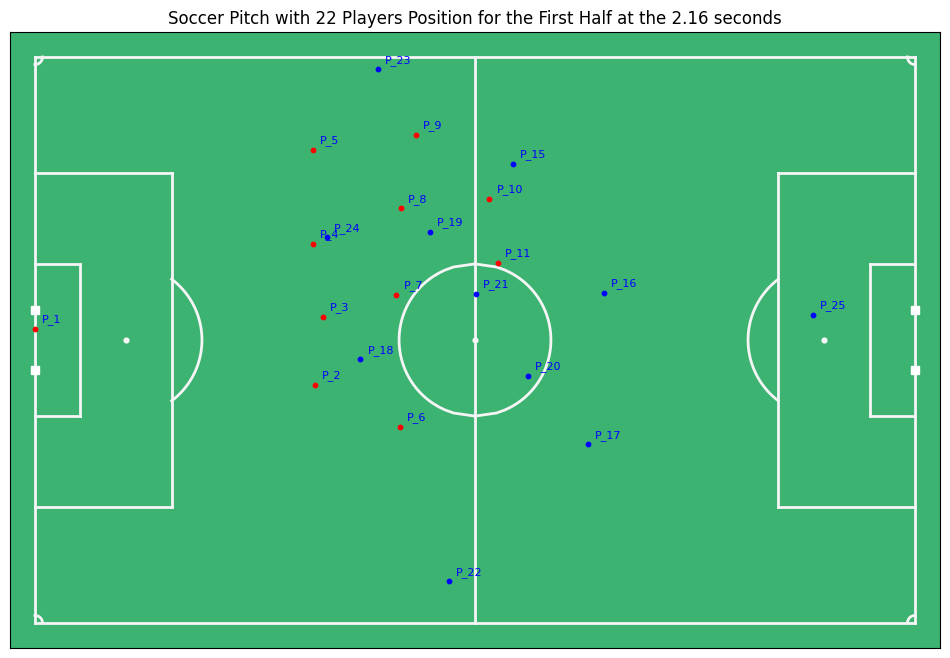

In [23]:
fig, ax = mviz.plot_pitch()

# Prepare player positions and their coordinates on the pitch
home_frame = period_1_data_home.iloc[53]
away_frame = period_1_data_away.iloc[53]
pos_x = [[float(home_frame.iloc[i]), period_1_data_home.columns[i]] for i in range(3, period_1_data_home.shape[1] - 2) if "-x" in period_1_data_home.columns[i]]
pos_y = [[float(home_frame.iloc[i]), period_1_data_home.columns[i]] for i in range(3, period_1_data_home.shape[1] - 2) if "-y" in period_1_data_home.columns[i]]
pos_x = pos_x + [[float(away_frame.iloc[i]), period_1_data_away.columns[i]] for i in range(3, period_1_data_away.shape[1]) if "-x" in period_1_data_away.columns[i]]
pos_y = pos_y + [[float(away_frame.iloc[i]), period_1_data_away.columns[i]] for i in range(3, period_1_data_away.shape[1]) if "-y" in period_1_data_away.columns[i]]

data_x, col_x = [item[0] for item in pos_x], [item[1] for item in pos_x]
data_y, col_y = [item[0] for item in pos_y], [item[1] for item in pos_y]

positions_x = pd.DataFrame([data_x], columns=col_x)
positions_y = pd.DataFrame([data_y], columns=col_y)

# Changing the dataset to meter or pitch coordinates
positions_x = mio.to_metric_coordinates(positions_x)
positions_y = mio.to_metric_coordinates(positions_y)

MEAN_X_POS = positions_x.mean(axis=1)[0]
DIRECTION_TO_GOAL = "<--" if MEAN_X_POS > 0 else "-->"
DIRECTION_TO_GOAL += " Direction To Goal"

# Annotate player names
for i, (x, y, name) in enumerate(zip(positions_x.iloc[0], positions_y.iloc[0], player_pos)):
    color = "red"
    if i > 10:
        color = "blue"
    ax.scatter(x, y, color=color, s=10, zorder=2)  # Plot red dot
    ax.annotate(name, (x, y), xytext=(5, 5), textcoords="offset points", fontsize=8, color='blue')
# ax.annotate(DIRECTION_TO_GOAL, (MEAN_X_POS, 29.55), xytext=(MEAN_X_POS, 29.55), textcoords="offset points", fontsize=18, color="red")

seconds = home_frame.iloc[2]
plt.title(f"Soccer Pitch with 22 Players Position for the First Half at the {seconds} seconds")
plt.show()

In [24]:
period_1_data_home

Period  Frame  Time[s] Home-P_1-x  Home-P_1-y Home-P_2-x  Home-P_2-y  \
1           1      1     0.04    0.00082     0.48238    0.32648     0.65322   
2           1      2     0.08    0.00096     0.48238    0.32648     0.65322   
3           1      3     0.12    0.00114     0.48238    0.32648     0.65322   
4           1      4     0.16    0.00121     0.48238    0.32622     0.65317   
5           1      5      0.2    0.00129     0.48238    0.32597     0.65269   
...       ...    ...      ...        ...         ...        ...         ...   
70574       1  70574  2822.96    0.01778     0.53494        NaN         NaN   
70575       1  70575     2823    0.01749     0.53456        NaN         NaN   
70576       1  70576  2823.04    0.01721     0.53417        NaN         NaN   
70577       1  70577  2823.08    0.01692     0.53375        NaN         NaN   
70578       1  70578  2823.12     0.0166     0.53326        NaN         NaN   

      Home-P_3-x  Home-P_3-y Home-P_4-x  ...  Home-P_8-x Home-P_8-y  \
1        0.33701     0.48863    0.30927  ...     0.39125    0.32550   
2        0.33701     0.48863    0.30927  ...     0.39125    0.32550   
3        0.33701     0.48863    0.30927  ...     0.39125    0.32550   
4        0.33687     0.48988    0.30944  ...     0.39134    0.32566   
5        0.33664     0.49018    0.30948  ...     0.39141    0.32427   
...          ...         ...        ...  ...         ...        ...   
70574    0.27756     0.65976    0.25373  ...     0.16702    0.90591   
70575    0.27759     0.65985    0.25381  ...     0.16754    0.90616   
70576    0.27763     0.65984    0.25392  ...     0.16805    0.90643   
70577    0.27765     0.65980    0.25402  ...     0.16858    0.90670   
70578    0.27771     0.65978    0.25416  ...     0.16908    0.90694   

       Home-P_9-x Home-P_9-y  Home-P_10-x Home-P_10-y  Home-P_11-x  \
1         0.45388    0.21174      0.52697     0.37980      0.55243   
2         0.45388    0.21174      0.52697     0.37980      0.55243   
3         0.45388    0.21174      0.52697     0.37980      0.55243   
4         0.45379    0.21053      0.52731     0.38010      0.55236   
5         0.45376    0.20950      0.52737     0.37991      0.55202   
...           ...        ...          ...         ...          ...   
70574     0.43171    0.30453      0.49579     0.69774      0.58339   
70575     0.43177    0.30524      0.49574     0.69820       0.5835   
70576     0.43183    0.30597      0.49569     0.69863      0.58359   
70577     0.43189    0.30673      0.49565     0.69907      0.58369   
70578     0.43193    0.30744       0.4956     0.69953      0.58379   

      Home-P_11-y   ball-x   ball-y  
1         0.43269  0.45472  0.38709  
2         0.43269  0.49645  0.40656  
3         0.43269  0.53716  0.42556  
4         0.43313  0.55346  0.42231  
5         0.43311  0.55512  0.40570  
...           ...      ...      ...  
70574     0.18427  0.16653  0.90563  
70575     0.18507  0.16704  0.90591  
70576     0.18591  0.16755  0.90617  
70577     0.18678  0.16807  0.90643  
70578     0.18750  0.16859  0.90670  

[40860 rows x 27 columns]

In [25]:
period_1_data_away

Period  Frame  Time[s] Away-P_25-x  Away-P_25-y Away-P_15-x  \
1           1      1     0.04     0.90509      0.47462     0.58393   
2           1      2     0.08     0.90494      0.47462     0.58393   
3           1      3     0.12     0.90434      0.47463     0.58393   
4           1      4     0.16     0.90377      0.47463     0.58351   
5           1      5      0.2     0.90324      0.47464     0.58291   
...       ...    ...      ...         ...          ...         ...   
70574       1  70574  2822.96     0.82272      0.54015     0.52001   
70575       1  70575     2823     0.82221      0.54034     0.51993   
70576       1  70576  2823.04     0.82171      0.54054     0.51987   
70577       1  70577  2823.08     0.82122      0.54073     0.51979   
70578       1  70578  2823.12     0.82072      0.54093     0.51972   

       Away-P_15-y Away-P_16-x  Away-P_16-y Away-P_17-x  ...  Away-P_21-x  \
1          0.20794     0.67658      0.46710      0.6731  ...      0.55243   
2          0.20794     0.67658      0.46710      0.6731  ...      0.55243   
3          0.20794     0.67658      0.46710      0.6731  ...      0.55243   
4          0.20868      0.6764      0.46762     0.67279  ...      0.55236   
5          0.21039     0.67599      0.46769     0.67253  ...      0.55202   
...            ...         ...          ...         ...  ...          ...   
70574      0.40586     0.52967      0.59474     0.49615  ...      0.42717   
70575      0.40687     0.52965      0.59562     0.49607  ...      0.42774   
70576      0.40784     0.52964      0.59651     0.49599  ...       0.4283   
70577      0.40882     0.52962      0.59742     0.49591  ...      0.42887   
70578      0.40983      0.5296      0.59829     0.49583  ...      0.42944   

      Away-P_21-y  Away-P_22-x Away-P_22-y  Away-P_23-x Away-P_23-y  \
1         0.43269      0.50067     0.94322      0.43693     0.05002   
2         0.43269      0.50067     0.94322      0.43693     0.05002   
3         0.43269      0.50067     0.94322      0.43693     0.05002   
4         0.43313      0.50034     0.94391      0.43644     0.05038   
5         0.43311      0.50017     0.94434       0.4358     0.04977   
...           ...          ...         ...          ...         ...   
70574     0.78415      0.51516     0.76263      0.29943     0.46791   
70575     0.78591      0.51511     0.76364      0.29967     0.46871   
70576     0.78765      0.51507     0.76462      0.29991     0.46948   
70577     0.78942      0.51504     0.76561      0.30016     0.47032   
70578     0.79116      0.51499     0.76658      0.30043     0.47111   

       Away-P_24-x Away-P_24-y   ball-x   ball-y  
1          0.37833     0.27383  0.45472  0.38709  
2          0.37833     0.27383  0.49645  0.40656  
3          0.37833     0.27383  0.53716  0.42556  
4          0.37756     0.27473  0.55346  0.42231  
5          0.37663     0.27543  0.55512  0.40570  
...            ...         ...      ...      ...  
70574      0.26227     0.66922  0.16653  0.90563  
70575      0.26259     0.66986  0.16704  0.90591  
70576      0.26293     0.67046  0.16755  0.90617  
70577      0.26325     0.67102  0.16807  0.90643  
70578      0.26361     0.67169  0.16859  0.90670  

[40860 rows x 27 columns]

## Tracking for individual Players for the First Period

In [26]:
period_1_data = pd.concat([period_1_data_home.iloc[:, :-2],  period_1_data_away.iloc[:, 3:]], axis=1)

In [27]:
period_1_data

Period  Frame  Time[s] Home-P_1-x  Home-P_1-y Home-P_2-x  Home-P_2-y  \
1           1      1     0.04    0.00082     0.48238    0.32648     0.65322   
2           1      2     0.08    0.00096     0.48238    0.32648     0.65322   
3           1      3     0.12    0.00114     0.48238    0.32648     0.65322   
4           1      4     0.16    0.00121     0.48238    0.32622     0.65317   
5           1      5      0.2    0.00129     0.48238    0.32597     0.65269   
...       ...    ...      ...        ...         ...        ...         ...   
70574       1  70574  2822.96    0.01778     0.53494        NaN         NaN   
70575       1  70575     2823    0.01749     0.53456        NaN         NaN   
70576       1  70576  2823.04    0.01721     0.53417        NaN         NaN   
70577       1  70577  2823.08    0.01692     0.53375        NaN         NaN   
70578       1  70578  2823.12     0.0166     0.53326        NaN         NaN   

      Home-P_3-x  Home-P_3-y Home-P_4-x  ...  Away-P_21-x Away-P_21-y  \
1        0.33701     0.48863    0.30927  ...      0.55243     0.43269   
2        0.33701     0.48863    0.30927  ...      0.55243     0.43269   
3        0.33701     0.48863    0.30927  ...      0.55243     0.43269   
4        0.33687     0.48988    0.30944  ...      0.55236     0.43313   
5        0.33664     0.49018    0.30948  ...      0.55202     0.43311   
...          ...         ...        ...  ...          ...         ...   
70574    0.27756     0.65976    0.25373  ...      0.42717     0.78415   
70575    0.27759     0.65985    0.25381  ...      0.42774     0.78591   
70576    0.27763     0.65984    0.25392  ...       0.4283     0.78765   
70577    0.27765     0.65980    0.25402  ...      0.42887     0.78942   
70578    0.27771     0.65978    0.25416  ...      0.42944     0.79116   

       Away-P_22-x Away-P_22-y  Away-P_23-x Away-P_23-y  Away-P_24-x  \
1          0.50067     0.94322      0.43693     0.05002      0.37833   
2          0.50067     0.94322      0.43693     0.05002      0.37833   
3          0.50067     0.94322      0.43693     0.05002      0.37833   
4          0.50034     0.94391      0.43644     0.05038      0.37756   
5          0.50017     0.94434       0.4358     0.04977      0.37663   
...            ...         ...          ...         ...          ...   
70574      0.51516     0.76263      0.29943     0.46791      0.26227   
70575      0.51511     0.76364      0.29967     0.46871      0.26259   
70576      0.51507     0.76462      0.29991     0.46948      0.26293   
70577      0.51504     0.76561      0.30016     0.47032      0.26325   
70578      0.51499     0.76658      0.30043     0.47111      0.26361   

      Away-P_24-y   ball-x   ball-y  
1         0.27383  0.45472  0.38709  
2         0.27383  0.49645  0.40656  
3         0.27383  0.53716  0.42556  
4         0.27473  0.55346  0.42231  
5         0.27543  0.55512  0.40570  
...           ...      ...      ...  
70574     0.66922  0.16653  0.90563  
70575     0.66986  0.16704  0.90591  
70576     0.67046  0.16755  0.90617  
70577     0.67102  0.16807  0.90643  
70578     0.67169  0.16859  0.90670  

[40860 rows x 49 columns]

In [28]:
def player_tracking(dataset: pd.DataFrame, players: list[int] = [11], plot_ball: bool =True, use_annotation: bool = False, sides: list[str] = None, markersize: int = 7):
    fig, ax = mviz.plot_pitch()
    ball_is_not_there = plot_ball
    title = "Player, and Side at each intervals"
    if use_annotation:
        title = "Player, and Frame at each intervals"
    
    for i, (player, side) in enumerate(zip(players, sides)):
        x = f"{side}-P_{player}-x"
        y = f"{side}-P_{player}-y"
    
        # Prepare player positions and their coordinates on the pitch
        data_x = pd.to_numeric(dataset[x], errors='coerce')
        data_y = pd.to_numeric(dataset[y], errors='coerce')
        
        # Create DataFrames with a single column for x and y coordinate of a player
        positions_x = pd.DataFrame(data_x, columns=[x])
        positions_y = pd.DataFrame(data_y, columns=[y])
        
        # Changing the dataset to metric or pitch coordinates
        positions_x = mio.to_metric_coordinates(positions_x)
        positions_y = mio.to_metric_coordinates(positions_y)

        color = color_map[i % len(color_map)]
        
        # Plot player movement with arrows
        for j in range(len(positions_x) - 1):
            dx = positions_x[x].iloc[j+1] - positions_x[x].iloc[j]
            dy = positions_y[y].iloc[j+1] - positions_y[y].iloc[j]
            if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                ax.arrow(positions_x[x].iloc[j], positions_y[y].iloc[j], dx, dy, head_width=1.2, head_length=1.2, fc=color, ec=color, linestyle="dotted", length_includes_head=True)

        # Plot the player path with dots and lines
        if use_annotation:
            for i in range(len(positions_x)):
                ax.plot(positions_x[x].iloc[i], positions_y[y].iloc[i], marker=".", linestyle="-.", markersize=markersize, color=color, zorder=3, label=f"P{use_annotation[i]} - {positions_x.index[i]}")
                ax.text(positions_x[x].iloc[i], positions_y[y].iloc[i], positions_x.index[i], fontsize=12, ha='right')
        else:
            ax.plot(positions_x[x], positions_y[y], marker=".", linestyle="-.", markersize=markersize, color=color, zorder=3, label=f"Player {player} - {side}")
        ax.plot(positions_x[x].iloc[0], positions_y[y].iloc[0], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="green", zorder=3)
        ax.plot(positions_x[x].iloc[-1], positions_y[y].iloc[-1], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="red", zorder=3)
                    
        # ax.annotate("Start Point", (positions_x[x].iloc[0], positions_y[y].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)
        # ax.annotate("End Point", (positions_x[x].iloc[-1], positions_y[y].iloc[-1]), xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)

    if ball_is_not_there:
        ba_x = pd.to_numeric(dataset["ball-x"], errors='coerce')
        ba_y = pd.to_numeric(dataset["ball-y"], errors='coerce')
        
        ba_x = mio.to_metric_coordinates(pd.DataFrame(ba_x, columns=["ball-x"]))
        ba_y = mio.to_metric_coordinates(pd.DataFrame(ba_y, columns=["ball-y"]))
        
        ax.plot(ba_x["ball-x"], ba_y["ball-y"], marker=".", linestyle="-.", markersize=int(markersize * 1.5), color="black", zorder=2, label="Ball")
        ax.plot(ba_x["ball-x"].iloc[0], ba_y["ball-y"].iloc[0], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="green", zorder=2)
        ax.plot(ba_x["ball-x"].iloc[-1], ba_y["ball-y"].iloc[-1], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="red", zorder=2)
        
        # Ball movement arrows
        for j in range(len(ba_x) - 1):
            dx = ba_x["ball-x"].iloc[j+1] - ba_x["ball-x"].iloc[j]
            dy = ba_y["ball-y"].iloc[j+1] - ba_y["ball-y"].iloc[j]
            if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                ax.arrow(ba_x["ball-x"].iloc[j], ba_y["ball-y"].iloc[j], dx, dy, head_width=1.2, head_length=1.2, fc='black', ec='black', linestyle="dotted", length_includes_head=True)
                
        # ax.annotate("Start Point", (ba_x["ball-x"].iloc[0], ba_y["ball-y"].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")
        # ax.annotate("End Point", (ba_x["ball-x"].iloc[-1], ba_y["ball-y"].iloc[-1]), xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")
        
    ball_is_not_there = False
    
    start_seconds = dataset["Time[s]"].iloc[0]
    end_seconds = dataset["Time[s]"].iloc[-1]
    pl = [i for i in players]
    ax.set_title(f"Tracking for Player {pl} in the First Half from {start_seconds} seconds to {end_seconds} seconds")
    ax.legend(title=title, loc="upper left", fontsize=8)
        
    plt.tight_layout()
    plt.show()

In [29]:
# player_tracking(period_1_data_home)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Grouping players time interval on 1 second interval

In [30]:
period_1_data

Period  Frame  Time[s] Home-P_1-x  Home-P_1-y Home-P_2-x  Home-P_2-y  \
1           1      1     0.04    0.00082     0.48238    0.32648     0.65322   
2           1      2     0.08    0.00096     0.48238    0.32648     0.65322   
3           1      3     0.12    0.00114     0.48238    0.32648     0.65322   
4           1      4     0.16    0.00121     0.48238    0.32622     0.65317   
5           1      5      0.2    0.00129     0.48238    0.32597     0.65269   
...       ...    ...      ...        ...         ...        ...         ...   
70574       1  70574  2822.96    0.01778     0.53494        NaN         NaN   
70575       1  70575     2823    0.01749     0.53456        NaN         NaN   
70576       1  70576  2823.04    0.01721     0.53417        NaN         NaN   
70577       1  70577  2823.08    0.01692     0.53375        NaN         NaN   
70578       1  70578  2823.12     0.0166     0.53326        NaN         NaN   

      Home-P_3-x  Home-P_3-y Home-P_4-x  ...  Away-P_21-x Away-P_21-y  \
1        0.33701     0.48863    0.30927  ...      0.55243     0.43269   
2        0.33701     0.48863    0.30927  ...      0.55243     0.43269   
3        0.33701     0.48863    0.30927  ...      0.55243     0.43269   
4        0.33687     0.48988    0.30944  ...      0.55236     0.43313   
5        0.33664     0.49018    0.30948  ...      0.55202     0.43311   
...          ...         ...        ...  ...          ...         ...   
70574    0.27756     0.65976    0.25373  ...      0.42717     0.78415   
70575    0.27759     0.65985    0.25381  ...      0.42774     0.78591   
70576    0.27763     0.65984    0.25392  ...       0.4283     0.78765   
70577    0.27765     0.65980    0.25402  ...      0.42887     0.78942   
70578    0.27771     0.65978    0.25416  ...      0.42944     0.79116   

       Away-P_22-x Away-P_22-y  Away-P_23-x Away-P_23-y  Away-P_24-x  \
1          0.50067     0.94322      0.43693     0.05002      0.37833   
2          0.50067     0.94322      0.43693     0.05002      0.37833   
3          0.50067     0.94322      0.43693     0.05002      0.37833   
4          0.50034     0.94391      0.43644     0.05038      0.37756   
5          0.50017     0.94434       0.4358     0.04977      0.37663   
...            ...         ...          ...         ...          ...   
70574      0.51516     0.76263      0.29943     0.46791      0.26227   
70575      0.51511     0.76364      0.29967     0.46871      0.26259   
70576      0.51507     0.76462      0.29991     0.46948      0.26293   
70577      0.51504     0.76561      0.30016     0.47032      0.26325   
70578      0.51499     0.76658      0.30043     0.47111      0.26361   

      Away-P_24-y   ball-x   ball-y  
1         0.27383  0.45472  0.38709  
2         0.27383  0.49645  0.40656  
3         0.27383  0.53716  0.42556  
4         0.27473  0.55346  0.42231  
5         0.27543  0.55512  0.40570  
...           ...      ...      ...  
70574     0.66922  0.16653  0.90563  
70575     0.66986  0.16704  0.90591  
70576     0.67046  0.16755  0.90617  
70577     0.67102  0.16807  0.90643  
70578     0.67169  0.16859  0.90670  

[40860 rows x 49 columns]

In [31]:
period_1_data = period_1_data.drop(columns=["Frame"])

In [32]:
period_1_data

Period  Time[s] Home-P_1-x  Home-P_1-y Home-P_2-x  Home-P_2-y  \
1           1     0.04    0.00082     0.48238    0.32648     0.65322   
2           1     0.08    0.00096     0.48238    0.32648     0.65322   
3           1     0.12    0.00114     0.48238    0.32648     0.65322   
4           1     0.16    0.00121     0.48238    0.32622     0.65317   
5           1      0.2    0.00129     0.48238    0.32597     0.65269   
...       ...      ...        ...         ...        ...         ...   
70574       1  2822.96    0.01778     0.53494        NaN         NaN   
70575       1     2823    0.01749     0.53456        NaN         NaN   
70576       1  2823.04    0.01721     0.53417        NaN         NaN   
70577       1  2823.08    0.01692     0.53375        NaN         NaN   
70578       1  2823.12     0.0166     0.53326        NaN         NaN   

      Home-P_3-x  Home-P_3-y Home-P_4-x  Home-P_4-y  ... Away-P_21-x  \
1        0.33701     0.48863    0.30927     0.35529  ...     0.55243   
2        0.33701     0.48863    0.30927     0.35529  ...     0.55243   
3        0.33701     0.48863    0.30927     0.35529  ...     0.55243   
4        0.33687     0.48988    0.30944     0.35554  ...     0.55236   
5        0.33664     0.49018    0.30948     0.35528  ...     0.55202   
...          ...         ...        ...         ...  ...         ...   
70574    0.27756     0.65976    0.25373     0.47652  ...     0.42717   
70575    0.27759     0.65985    0.25381     0.47726  ...     0.42774   
70576    0.27763     0.65984    0.25392     0.47801  ...      0.4283   
70577    0.27765     0.65980    0.25402     0.47872  ...     0.42887   
70578    0.27771     0.65978    0.25416     0.47949  ...     0.42944   

       Away-P_21-y Away-P_22-x  Away-P_22-y Away-P_23-x  Away-P_23-y  \
1          0.43269     0.50067      0.94322     0.43693      0.05002   
2          0.43269     0.50067      0.94322     0.43693      0.05002   
3          0.43269     0.50067      0.94322     0.43693      0.05002   
4          0.43313     0.50034      0.94391     0.43644      0.05038   
5          0.43311     0.50017      0.94434      0.4358      0.04977   
...            ...         ...          ...         ...          ...   
70574      0.78415     0.51516      0.76263     0.29943      0.46791   
70575      0.78591     0.51511      0.76364     0.29967      0.46871   
70576      0.78765     0.51507      0.76462     0.29991      0.46948   
70577      0.78942     0.51504      0.76561     0.30016      0.47032   
70578      0.79116     0.51499      0.76658     0.30043      0.47111   

      Away-P_24-x  Away-P_24-y   ball-x   ball-y  
1         0.37833      0.27383  0.45472  0.38709  
2         0.37833      0.27383  0.49645  0.40656  
3         0.37833      0.27383  0.53716  0.42556  
4         0.37756      0.27473  0.55346  0.42231  
5         0.37663      0.27543  0.55512  0.40570  
...           ...          ...      ...      ...  
70574     0.26227      0.66922  0.16653  0.90563  
70575     0.26259      0.66986  0.16704  0.90591  
70576     0.26293      0.67046  0.16755  0.90617  
70577     0.26325      0.67102  0.16807  0.90643  
70578     0.26361      0.67169  0.16859  0.90670  

[40860 rows x 48 columns]

In [33]:
# Convert all columns to numeric
temp_data = copy.deepcopy(period_1_data)
for col in temp_data.columns:
    if col != "Period" and col != "Time[s]":
        temp_data[col] = pd.to_numeric(temp_data[col], errors='coerce')
        period_1_data[col] = pd.to_numeric(period_1_data[col], errors='coerce')
    else:
        period_1_data[col] = pd.to_numeric(period_1_data[col], errors='coerce')
        temp_data[col] = pd.to_numeric(temp_data[col], errors='coerce').astype(int)

avg_1_sec = pd.DataFrame()

# Calculate averages for each column
for col in temp_data.columns:
    averages = []
    for i in range(0, len(temp_data), 25):
        group = temp_data[col].iloc[i:i+25]
        avg = group.mean()
        averages.append(avg)
    
    # Add the averages for this column to avg_1_sec
    avg_1_sec[col] = averages   

# avg_1_sec.reset_index(drop=True, inplace=True)
avg_1_sec.index = range(1, len(avg_1_sec) + 1)

In [34]:
avg_1_sec = avg_1_sec.iloc[:200]
avg_1_sec

Period  Time[s]  Home-P_1-x  Home-P_1-y  Home-P_2-x  Home-P_2-y  \
1       1.0     0.04    0.000877    0.481507    0.325389    0.641362   
2       1.0     1.04    0.000079    0.480437    0.321496    0.603216   
3       1.0     2.04   -0.000037    0.480290    0.317922    0.568887   
4       1.0     3.04    0.003391    0.481172    0.322266    0.562472   
5       1.0     4.04    0.011957    0.483703    0.322910    0.600081   
..      ...      ...         ...         ...         ...         ...   
196     1.0   355.04    0.179453    0.459438    0.501495    0.596473   
197     1.0   356.04    0.180010    0.457524    0.490118    0.566355   
198     1.0   357.04    0.173793    0.455673    0.467690    0.532747   
199     1.0   358.04    0.159242    0.449422    0.433250    0.506218   
200     1.0   359.04    0.131113    0.434833    0.387092    0.495604   

     Home-P_3-x  Home-P_3-y  Home-P_4-x  Home-P_4-y  ...  Away-P_21-x  \
1      0.335298    0.485002    0.312224    0.349931  ...     0.544800   
2      0.329797    0.467672    0.315984    0.333462  ...     0.518190   
3      0.326641    0.459156    0.316180    0.334966  ...     0.494910   
4      0.329050    0.474362    0.319524    0.362218  ...     0.486348   
5      0.328616    0.516325    0.320089    0.396770  ...     0.482298   
..          ...         ...         ...         ...  ...          ...   
196    0.484056    0.443852    0.501557    0.286700  ...     0.699573   
197    0.475467    0.398898    0.500046    0.262508  ...     0.693652   
198    0.448814    0.348675    0.473997    0.254810  ...     0.677927   
199    0.397891    0.315506    0.419204    0.250844  ...     0.650726   
200    0.328692    0.285060    0.346556    0.232917  ...     0.611798   

     Away-P_21-y  Away-P_22-x  Away-P_22-y  Away-P_23-x  Away-P_23-y  \
1       0.426795     0.497062     0.940150     0.429224     0.040951   
2       0.416918     0.483103     0.930252     0.406186     0.023923   
3       0.425251     0.461356     0.926942     0.380586     0.025783   
4       0.458666     0.433266     0.932593     0.356783     0.048086   
5       0.515448     0.391182     0.935498     0.338114     0.083684   
..           ...          ...          ...          ...          ...   
196     0.465714     0.723452     0.676456     0.545791     0.413188   
197     0.464044     0.696727     0.696555     0.532776     0.359102   
198     0.459639     0.659947     0.729219     0.492245     0.301916   
199     0.454049     0.617467     0.750549     0.427250     0.273306   
200     0.451359     0.573467     0.746735     0.347434     0.260502   

     Away-P_24-x  Away-P_24-y    ball-x    ball-y  
1       0.367105     0.282471  0.558469  0.289608  
2       0.342739     0.303210  0.552782  0.197110  
3       0.329885     0.329594  0.465489  0.291620  
4       0.332081     0.358466  0.471031  0.404410  
5       0.337123     0.383941  0.482605  0.512861  
..           ...          ...       ...       ...  
196     0.521846     0.241194  0.727995  0.077326  
197     0.522570     0.227405  0.713896  0.104764  
198     0.519830     0.212250  0.692656  0.114278  
199     0.502735     0.209272  0.585728  0.124817  
200     0.464892     0.228580  0.465460  0.135560  

[200 rows x 48 columns]

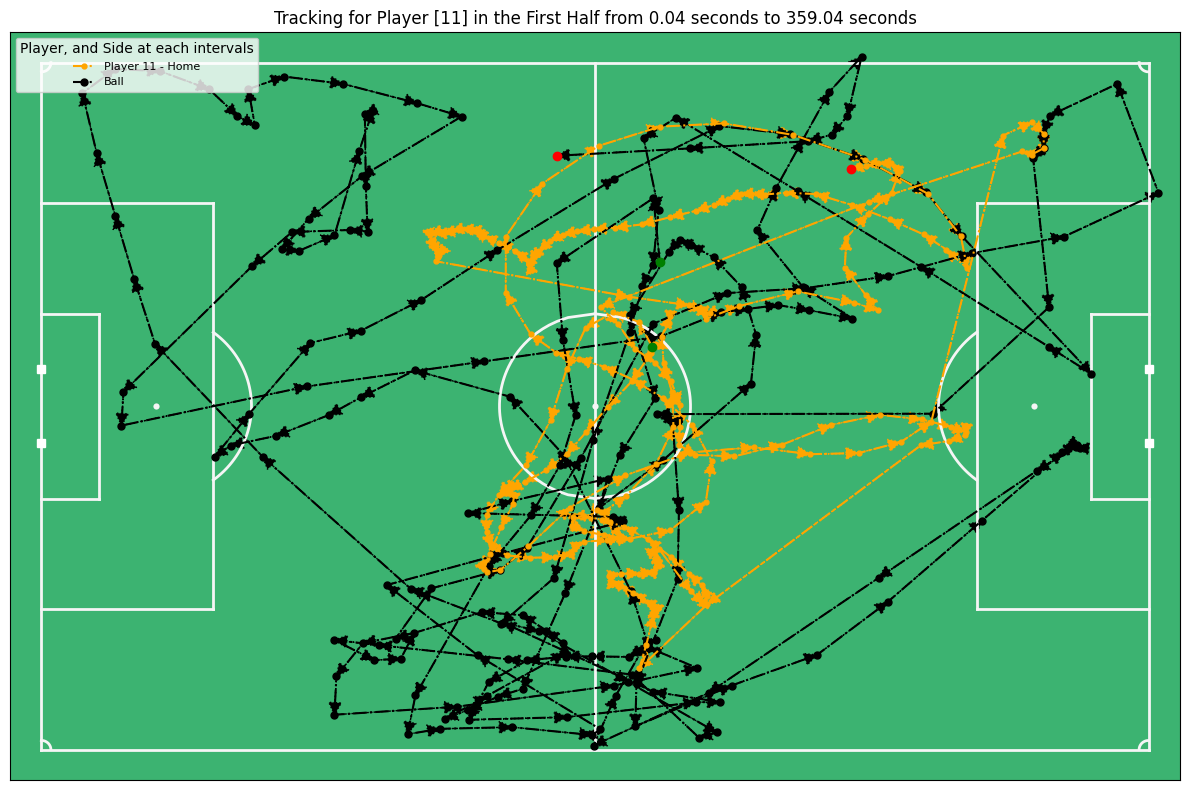

In [35]:
player_tracking(avg_1_sec.loc[:"Home-P_11-y"], plot_ball=True, sides=["Home"]*avg_1_sec.loc[:"Home-P_11-y"].shape[1])

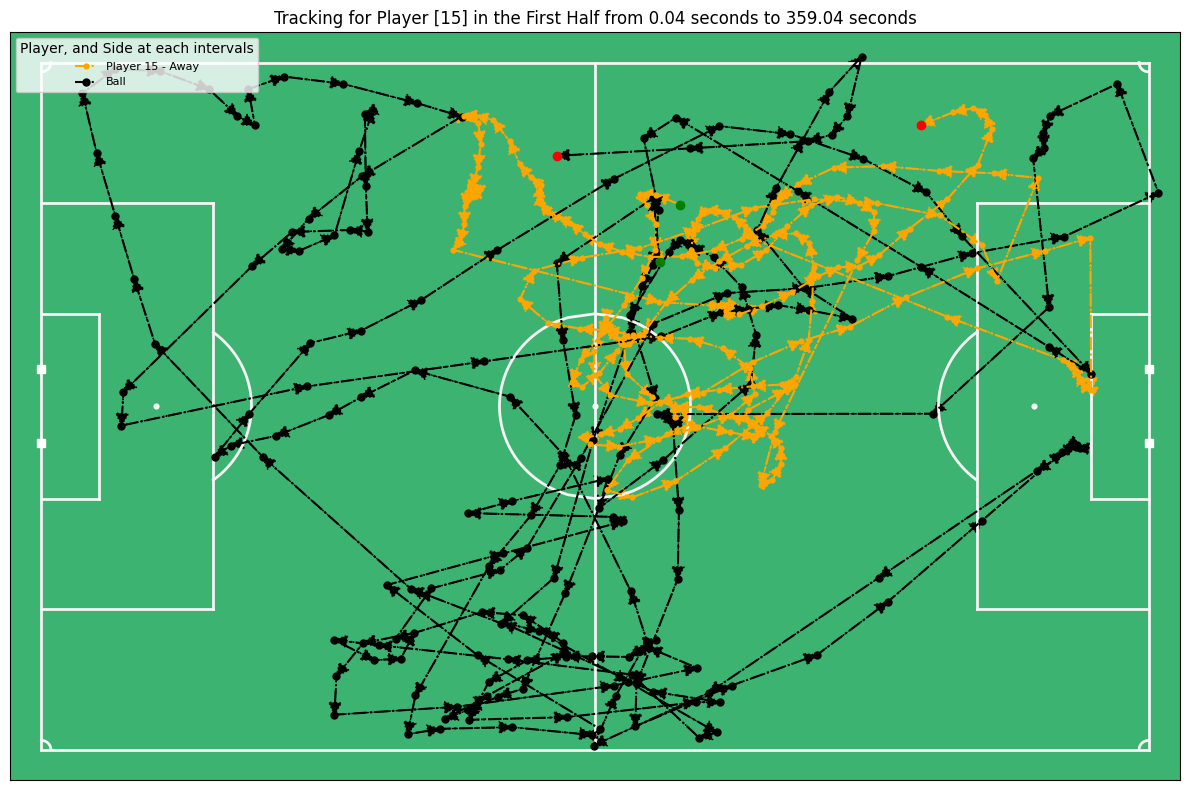

In [36]:
player_tracking(avg_1_sec, [15], sides=["Away"]*1)

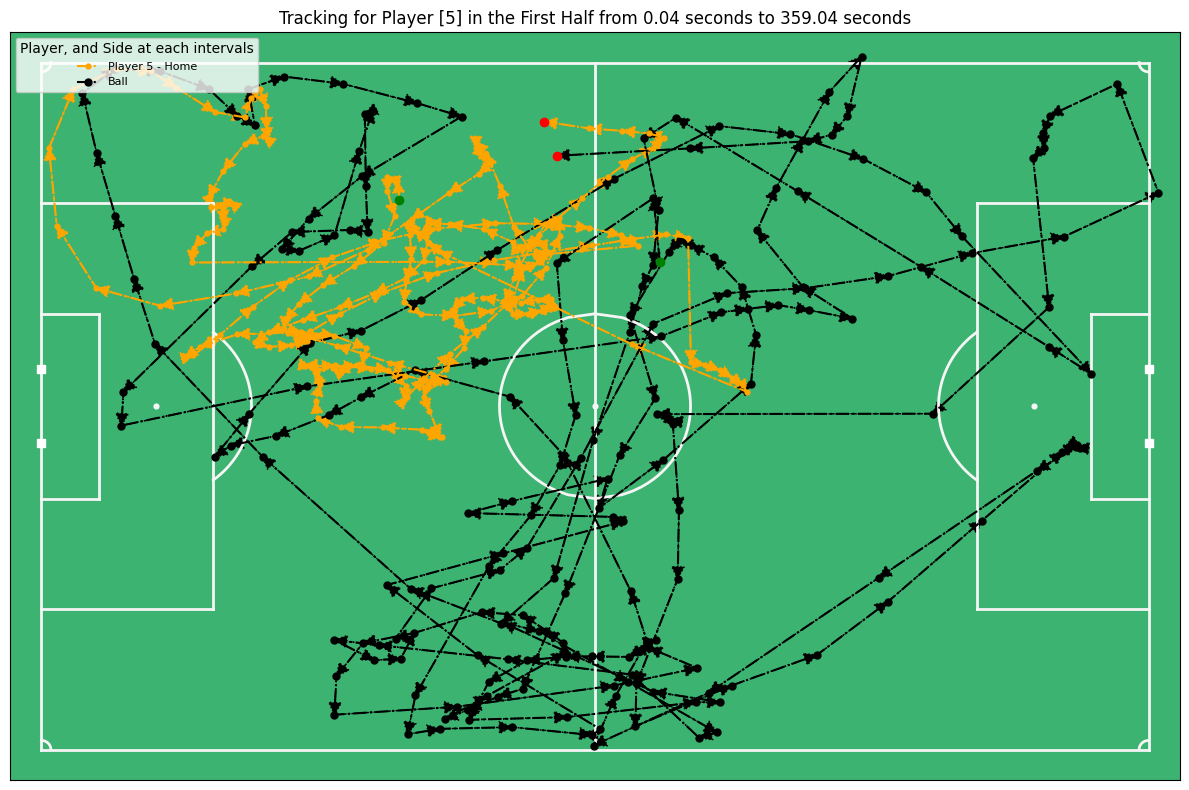

In [37]:
player_tracking(avg_1_sec, [5], sides=["Home"])

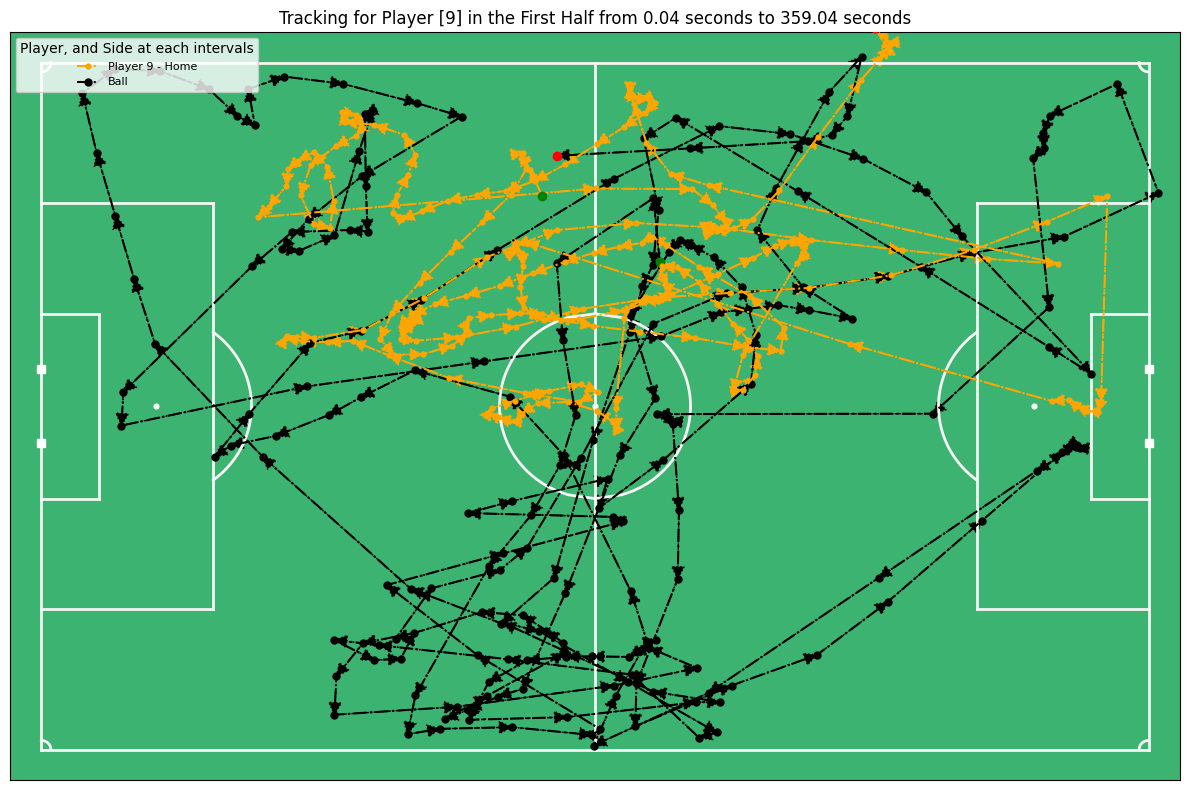

In [38]:
player_tracking(avg_1_sec, [9], sides=["Home"])

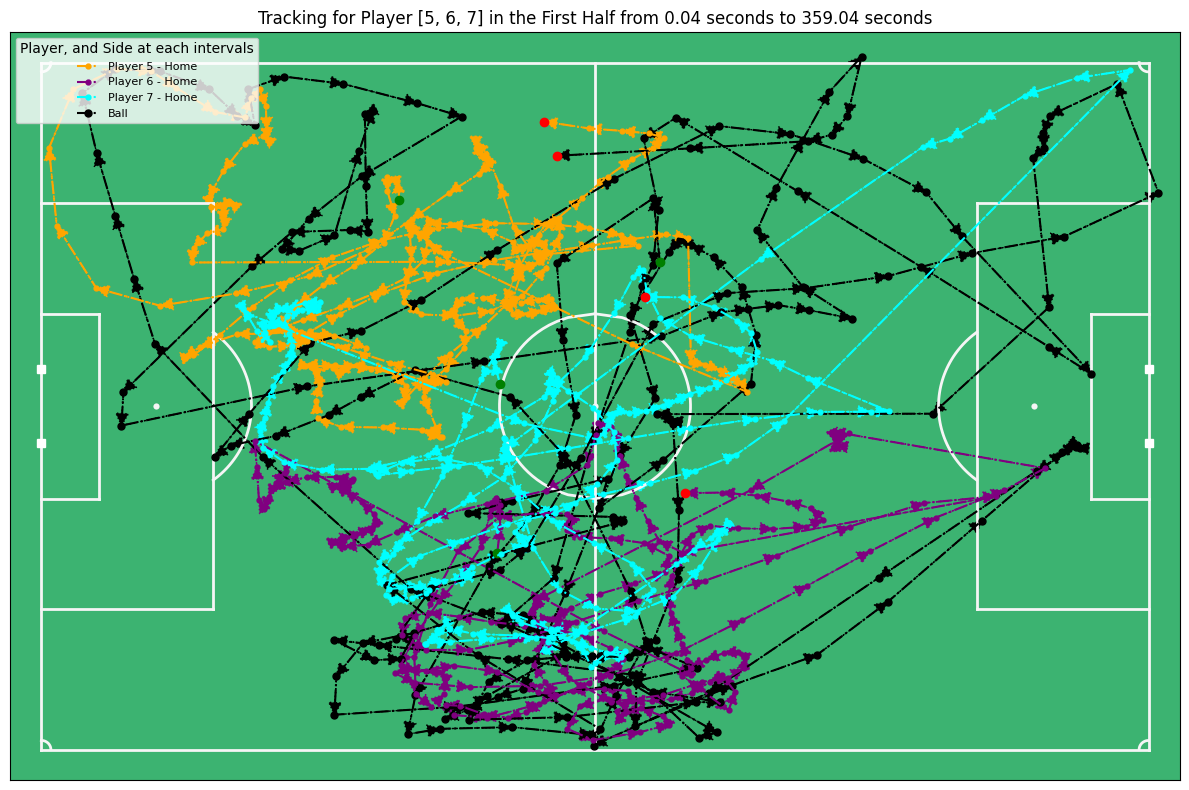

In [39]:
player_tracking(avg_1_sec, [5, 6, 7], sides=["Home"]*3)

In [40]:
# Calculate balls and players speed and direction
def speed_dir(dataset: pd.DataFrame) -> pd.DataFrame:
    temp_data = copy.deepcopy(dataset)
    player_columns = temp_data.columns[2:]

    for i in range(0, player_columns.shape[0] - 1, 2):
        # Calculate Euclidean distance between consecutive points
        ply_x, ply_y = player_columns[i], player_columns[i + 1]
        
        x_diff = temp_data[ply_x].diff()
        y_diff = temp_data[ply_y].diff()
        distance = np.sqrt(x_diff**2 + y_diff**2)
        
        # Calculate time difference between frames
        time_diff = temp_data['Time[s]'].diff()
        
        # Calculate speed (distance / time)
        # Note: First row will be NaN as we can't calculate speed for a single point
        speed = distance / time_diff
        direction = np.arctan2(x_diff, y_diff)

        if "ball" in ply_x:
            temp_data[f"ball_speed"] = speed
            temp_data[f"ball_direction"] = direction
        else:
            players_num = ply_x[7]
            if len(ply_x) == 11:
                players_num = ply_x[7:9]

            temp_data[f"P_{players_num}_speed"] = speed
            temp_data[f"P_{players_num}_direction"] = direction

    return temp_data

In [41]:
avg_1_sec

Period  Time[s]  Home-P_1-x  Home-P_1-y  Home-P_2-x  Home-P_2-y  \
1       1.0     0.04    0.000877    0.481507    0.325389    0.641362   
2       1.0     1.04    0.000079    0.480437    0.321496    0.603216   
3       1.0     2.04   -0.000037    0.480290    0.317922    0.568887   
4       1.0     3.04    0.003391    0.481172    0.322266    0.562472   
5       1.0     4.04    0.011957    0.483703    0.322910    0.600081   
..      ...      ...         ...         ...         ...         ...   
196     1.0   355.04    0.179453    0.459438    0.501495    0.596473   
197     1.0   356.04    0.180010    0.457524    0.490118    0.566355   
198     1.0   357.04    0.173793    0.455673    0.467690    0.532747   
199     1.0   358.04    0.159242    0.449422    0.433250    0.506218   
200     1.0   359.04    0.131113    0.434833    0.387092    0.495604   

     Home-P_3-x  Home-P_3-y  Home-P_4-x  Home-P_4-y  ...  Away-P_21-x  \
1      0.335298    0.485002    0.312224    0.349931  ...     0.544800   
2      0.329797    0.467672    0.315984    0.333462  ...     0.518190   
3      0.326641    0.459156    0.316180    0.334966  ...     0.494910   
4      0.329050    0.474362    0.319524    0.362218  ...     0.486348   
5      0.328616    0.516325    0.320089    0.396770  ...     0.482298   
..          ...         ...         ...         ...  ...          ...   
196    0.484056    0.443852    0.501557    0.286700  ...     0.699573   
197    0.475467    0.398898    0.500046    0.262508  ...     0.693652   
198    0.448814    0.348675    0.473997    0.254810  ...     0.677927   
199    0.397891    0.315506    0.419204    0.250844  ...     0.650726   
200    0.328692    0.285060    0.346556    0.232917  ...     0.611798   

     Away-P_21-y  Away-P_22-x  Away-P_22-y  Away-P_23-x  Away-P_23-y  \
1       0.426795     0.497062     0.940150     0.429224     0.040951   
2       0.416918     0.483103     0.930252     0.406186     0.023923   
3       0.425251     0.461356     0.926942     0.380586     0.025783   
4       0.458666     0.433266     0.932593     0.356783     0.048086   
5       0.515448     0.391182     0.935498     0.338114     0.083684   
..           ...          ...          ...          ...          ...   
196     0.465714     0.723452     0.676456     0.545791     0.413188   
197     0.464044     0.696727     0.696555     0.532776     0.359102   
198     0.459639     0.659947     0.729219     0.492245     0.301916   
199     0.454049     0.617467     0.750549     0.427250     0.273306   
200     0.451359     0.573467     0.746735     0.347434     0.260502   

     Away-P_24-x  Away-P_24-y    ball-x    ball-y  
1       0.367105     0.282471  0.558469  0.289608  
2       0.342739     0.303210  0.552782  0.197110  
3       0.329885     0.329594  0.465489  0.291620  
4       0.332081     0.358466  0.471031  0.404410  
5       0.337123     0.383941  0.482605  0.512861  
..           ...          ...       ...       ...  
196     0.521846     0.241194  0.727995  0.077326  
197     0.522570     0.227405  0.713896  0.104764  
198     0.519830     0.212250  0.692656  0.114278  
199     0.502735     0.209272  0.585728  0.124817  
200     0.464892     0.228580  0.465460  0.135560  

[200 rows x 48 columns]

# Tracking players closest to the ball using frames

In [42]:
period_1_data

Period  Time[s]  Home-P_1-x  Home-P_1-y  Home-P_2-x  Home-P_2-y  \
1           1     0.04     0.00082     0.48238     0.32648     0.65322   
2           1     0.08     0.00096     0.48238     0.32648     0.65322   
3           1     0.12     0.00114     0.48238     0.32648     0.65322   
4           1     0.16     0.00121     0.48238     0.32622     0.65317   
5           1     0.20     0.00129     0.48238     0.32597     0.65269   
...       ...      ...         ...         ...         ...         ...   
70574       1  2822.96     0.01778     0.53494         NaN         NaN   
70575       1  2823.00     0.01749     0.53456         NaN         NaN   
70576       1  2823.04     0.01721     0.53417         NaN         NaN   
70577       1  2823.08     0.01692     0.53375         NaN         NaN   
70578       1  2823.12     0.01660     0.53326         NaN         NaN   

       Home-P_3-x  Home-P_3-y  Home-P_4-x  Home-P_4-y  ...  Away-P_21-x  \
1         0.33701     0.48863     0.30927     0.35529  ...      0.55243   
2         0.33701     0.48863     0.30927     0.35529  ...      0.55243   
3         0.33701     0.48863     0.30927     0.35529  ...      0.55243   
4         0.33687     0.48988     0.30944     0.35554  ...      0.55236   
5         0.33664     0.49018     0.30948     0.35528  ...      0.55202   
...           ...         ...         ...         ...  ...          ...   
70574     0.27756     0.65976     0.25373     0.47652  ...      0.42717   
70575     0.27759     0.65985     0.25381     0.47726  ...      0.42774   
70576     0.27763     0.65984     0.25392     0.47801  ...      0.42830   
70577     0.27765     0.65980     0.25402     0.47872  ...      0.42887   
70578     0.27771     0.65978     0.25416     0.47949  ...      0.42944   

       Away-P_21-y  Away-P_22-x  Away-P_22-y  Away-P_23-x  Away-P_23-y  \
1          0.43269      0.50067      0.94322      0.43693      0.05002   
2          0.43269      0.50067      0.94322      0.43693      0.05002   
3          0.43269      0.50067      0.94322      0.43693      0.05002   
4          0.43313      0.50034      0.94391      0.43644      0.05038   
5          0.43311      0.50017      0.94434      0.43580      0.04977   
...            ...          ...          ...          ...          ...   
70574      0.78415      0.51516      0.76263      0.29943      0.46791   
70575      0.78591      0.51511      0.76364      0.29967      0.46871   
70576      0.78765      0.51507      0.76462      0.29991      0.46948   
70577      0.78942      0.51504      0.76561      0.30016      0.47032   
70578      0.79116      0.51499      0.76658      0.30043      0.47111   

       Away-P_24-x  Away-P_24-y   ball-x   ball-y  
1          0.37833      0.27383  0.45472  0.38709  
2          0.37833      0.27383  0.49645  0.40656  
3          0.37833      0.27383  0.53716  0.42556  
4          0.37756      0.27473  0.55346  0.42231  
5          0.37663      0.27543  0.55512  0.40570  
...            ...          ...      ...      ...  
70574      0.26227      0.66922  0.16653  0.90563  
70575      0.26259      0.66986  0.16704  0.90591  
70576      0.26293      0.67046  0.16755  0.90617  
70577      0.26325      0.67102  0.16807  0.90643  
70578      0.26361      0.67169  0.16859  0.90670  

[40860 rows x 48 columns]

In [43]:
sp_dir_period_1_data = speed_dir(period_1_data)

In [44]:
sp_dir_period_1_data

Period  Time[s]  Home-P_1-x  Home-P_1-y  Home-P_2-x  Home-P_2-y  \
1           1     0.04     0.00082     0.48238     0.32648     0.65322   
2           1     0.08     0.00096     0.48238     0.32648     0.65322   
3           1     0.12     0.00114     0.48238     0.32648     0.65322   
4           1     0.16     0.00121     0.48238     0.32622     0.65317   
5           1     0.20     0.00129     0.48238     0.32597     0.65269   
...       ...      ...         ...         ...         ...         ...   
70574       1  2822.96     0.01778     0.53494         NaN         NaN   
70575       1  2823.00     0.01749     0.53456         NaN         NaN   
70576       1  2823.04     0.01721     0.53417         NaN         NaN   
70577       1  2823.08     0.01692     0.53375         NaN         NaN   
70578       1  2823.12     0.01660     0.53326         NaN         NaN   

       Home-P_3-x  Home-P_3-y  Home-P_4-x  Home-P_4-y  ...  P_21_speed  \
1         0.33701     0.48863     0.30927     0.35529  ...         NaN   
2         0.33701     0.48863     0.30927     0.35529  ...    0.000000   
3         0.33701     0.48863     0.30927     0.35529  ...    0.000000   
4         0.33687     0.48988     0.30944     0.35554  ...    0.011138   
5         0.33664     0.49018     0.30948     0.35528  ...    0.008515   
...           ...         ...         ...         ...  ...         ...   
70574     0.27756     0.65976     0.25373     0.47652  ...    0.047202   
70575     0.27759     0.65985     0.25381     0.47726  ...    0.046250   
70576     0.27763     0.65984     0.25392     0.47801  ...    0.045697   
70577     0.27765     0.65980     0.25402     0.47872  ...    0.046488   
70578     0.27771     0.65978     0.25416     0.47949  ...    0.045775   

       P_21_direction  P_22_speed  P_22_direction  P_23_speed  P_23_direction  \
1                 NaN         NaN             NaN         NaN             NaN   
2            0.000000    0.000000        0.000000    0.000000        0.000000   
3            0.000000    0.000000        0.000000    0.000000        0.000000   
4           -0.157769    0.019121       -0.446106    0.015201       -0.937163   
5           -1.629552    0.011560       -0.376490    0.022103       -2.332199   
...               ...         ...             ...         ...             ...   
70574        0.306676    0.025031       -0.049958    0.022150        0.286051   
70575        0.313204    0.025281       -0.049465    0.020881        0.291457   
70576        0.311370    0.024520       -0.040794    0.020163        0.302145   
70577        0.311547    0.024761       -0.030294    0.021910        0.289271   
70578        0.316569    0.024282       -0.051501    0.020872        0.329326   

       P_24_speed  P_24_direction  ball_speed  ball_direction  
1             NaN             NaN         NaN             NaN  
2        0.000000        0.000000    1.151215        1.134248  
3        0.000000        0.000000    1.123138        1.134129  
4        0.029611       -0.707711    0.415521        1.767602  
5        0.029100       -0.925577    0.417319        3.041984  
...           ...             ...         ...             ...  
70574    0.016325        0.477345    0.014427        1.083897  
70575    0.017889        0.463648    0.014545        1.068706  
70576    0.017241        0.515549    0.014311        1.099336  
70577    0.016125        0.519146    0.014534        1.107149  
70578    0.019015        0.493051    0.014648        1.091883  

[40860 rows x 94 columns]

In [45]:
ply_tra = sp_dir_period_1_data.loc[:67852, "Home-P_1-x":]
ply_tra

Home-P_1-x  Home-P_1-y  Home-P_2-x  Home-P_2-y  Home-P_3-x  Home-P_3-y  \
1         0.00082     0.48238     0.32648     0.65322     0.33701     0.48863   
2         0.00096     0.48238     0.32648     0.65322     0.33701     0.48863   
3         0.00114     0.48238     0.32648     0.65322     0.33701     0.48863   
4         0.00121     0.48238     0.32622     0.65317     0.33687     0.48988   
5         0.00129     0.48238     0.32597     0.65269     0.33664     0.49018   
...           ...         ...         ...         ...         ...         ...   
67848     0.15661     0.40834         NaN         NaN     0.36823     0.29491   
67849     0.15642     0.40694         NaN         NaN     0.36713     0.29115   
67850     0.15621     0.40548         NaN         NaN     0.36606     0.28750   
67851     0.15598     0.40401         NaN         NaN     0.36501     0.28378   
67852     0.15576     0.40260         NaN         NaN     0.36397     0.28007   

       Home-P_4-x  Home-P_4-y  Home-P_5-x  Home-P_5-y  ...  P_21_speed  \
1         0.30927     0.35529     0.32137     0.21262  ...         NaN   
2         0.30927     0.35529     0.32137     0.21262  ...    0.000000   
3         0.30927     0.35529     0.32137     0.21262  ...    0.000000   
4         0.30944     0.35554     0.32142     0.21241  ...    0.011138   
5         0.30948     0.35528     0.32136     0.21159  ...    0.008515   
...           ...         ...         ...         ...  ...         ...   
67848     0.42944     0.42073     0.50192     0.14427  ...    0.043546   
67849     0.42775     0.42040     0.50111     0.14041  ...    0.043276   
67850     0.42606     0.42009     0.50032     0.13658  ...    0.042580   
67851     0.42435     0.41981     0.49956     0.13278  ...    0.041503   
67852     0.42265     0.41956     0.49882     0.12879  ...    0.042170   

       P_21_direction  P_22_speed  P_22_direction  P_23_speed  P_23_direction  \
1                 NaN         NaN             NaN         NaN             NaN   
2            0.000000    0.000000        0.000000    0.000000        0.000000   
3            0.000000    0.000000        0.000000    0.000000        0.000000   
4           -0.157769    0.019121       -0.446106    0.015201       -0.937163   
5           -1.629552    0.011560       -0.376490    0.022103       -2.332199   
...               ...         ...             ...         ...             ...   
67848       -2.544036    0.033422       -0.577630    0.127252        3.078684   
67849       -2.532760    0.033422       -0.577630    0.124524        3.075292   
67850       -2.535677    0.034345       -0.551655    0.127268        3.076723   
67851       -2.510139    0.033560       -0.583870    0.122064        3.069847   
67852       -2.528924    0.029538       -0.592697    0.122082        3.067805   

       P_24_speed  P_24_direction  ball_speed  ball_direction  
1             NaN             NaN         NaN             NaN  
2        0.000000        0.000000    1.151215        1.134248  
3        0.000000        0.000000    1.123138        1.134129  
4        0.029611       -0.707711    0.415521        1.767602  
5        0.029100       -0.925577    0.417319        3.041984  
...           ...             ...         ...             ...  
67848    0.067923       -2.748783    0.105499        3.072818  
67849    0.068568       -2.764472    0.105268        3.070285  
67850    0.071455       -2.776680    0.105499        3.072818  
67851    0.072215       -2.788089    0.105250        3.072654  
67852    0.073775       -2.799480    0.105499        3.072818  

[38646 rows x 92 columns]

In [46]:
players, ball, sp_dir = ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], ply_tra.loc[:,"ball-x":"ball-y"], ply_tra.loc[:,"P_1_speed":]

In [47]:
players.head()

Home-P_1-x  Home-P_1-y  Home-P_2-x  Home-P_2-y  Home-P_3-x  Home-P_3-y  \
1     0.00082     0.48238     0.32648     0.65322     0.33701     0.48863   
2     0.00096     0.48238     0.32648     0.65322     0.33701     0.48863   
3     0.00114     0.48238     0.32648     0.65322     0.33701     0.48863   
4     0.00121     0.48238     0.32622     0.65317     0.33687     0.48988   
5     0.00129     0.48238     0.32597     0.65269     0.33664     0.49018   

   Home-P_4-x  Home-P_4-y  Home-P_5-x  Home-P_5-y  ...  Away-P_20-x  \
1     0.30927     0.35529     0.32137     0.21262  ...      0.55960   
2     0.30927     0.35529     0.32137     0.21262  ...      0.55960   
3     0.30927     0.35529     0.32137     0.21262  ...      0.55960   
4     0.30944     0.35554     0.32142     0.21241  ...      0.55974   
5     0.30948     0.35528     0.32136     0.21159  ...      0.55992   

   Away-P_20-y  Away-P_21-x  Away-P_21-y  Away-P_22-x  Away-P_22-y  \
1      0.67775      0.55243      0.43269      0.50067      0.94322   
2      0.67775      0.55243      0.43269      0.50067      0.94322   
3      0.67775      0.55243      0.43269      0.50067      0.94322   
4      0.67776      0.55236      0.43313      0.50034      0.94391   
5      0.67791      0.55202      0.43311      0.50017      0.94434   

   Away-P_23-x  Away-P_23-y  Away-P_24-x  Away-P_24-y  
1      0.43693      0.05002      0.37833      0.27383  
2      0.43693      0.05002      0.37833      0.27383  
3      0.43693      0.05002      0.37833      0.27383  
4      0.43644      0.05038      0.37756      0.27473  
5      0.43580      0.04977      0.37663      0.27543  

[5 rows x 44 columns]

In [48]:
ball.head()

ball-x   ball-y
1  0.45472  0.38709
2  0.49645  0.40656
3  0.53716  0.42556
4  0.55346  0.42231
5  0.55512  0.40570

In [49]:
sp_dir.head()

P_1_speed  P_1_direction  P_2_speed  P_2_direction  P_3_speed  \
1        NaN            NaN        NaN            NaN        NaN   
2    0.00350       1.570796   0.000000       0.000000   0.000000   
3    0.00450       1.570796   0.000000       0.000000   0.000000   
4    0.00175       1.570796   0.006619      -1.760785   0.031445   
5    0.00200       1.570796   0.013530      -2.661418   0.009451   

   P_3_direction  P_4_speed  P_4_direction  P_5_speed  P_5_direction  ...  \
1            NaN        NaN            NaN        NaN            NaN  ...   
2       0.000000   0.000000       0.000000   0.000000       0.000000  ...   
3       0.000000   0.000000       0.000000   0.000000       0.000000  ...   
4      -0.111535   0.007558       0.597177   0.005397       2.907849  ...   
5      -0.654083   0.006576       2.988943   0.020555      -3.068552  ...   

   P_21_speed  P_21_direction  P_22_speed  P_22_direction  P_23_speed  \
1         NaN             NaN         NaN             NaN         NaN   
2    0.000000        0.000000    0.000000        0.000000    0.000000   
3    0.000000        0.000000    0.000000        0.000000    0.000000   
4    0.011138       -0.157769    0.019121       -0.446106    0.015201   
5    0.008515       -1.629552    0.011560       -0.376490    0.022103   

   P_23_direction  P_24_speed  P_24_direction  ball_speed  ball_direction  
1             NaN         NaN             NaN         NaN             NaN  
2        0.000000    0.000000        0.000000    1.151215        1.134248  
3        0.000000    0.000000        0.000000    1.123138        1.134129  
4       -0.937163    0.029611       -0.707711    0.415521        1.767602  
5       -2.332199    0.029100       -0.925577    0.417319        3.041984  

[5 rows x 46 columns]

In [50]:
result = pd.DataFrame(index=ply_tra.index)
result["Time[s]"] = sp_dir_period_1_data["Time[s]"]

for i in range(0, players.shape[1] - 1, 2):
    ply_x, ply_y = players.iloc[:, i], players.iloc[:, i + 1]
    eu_x = np.square(ply_x - ball["ball-x"])
    eu_y = np.square(ply_y - ball["ball-y"])
    distance = np.sqrt(eu_x + eu_y)
    result[f"{players.columns[i][:-2]}"] = distance

In [51]:
result

Time[s]  Home-P_1  Home-P_2  Home-P_3  Home-P_4  Home-P_5  Home-P_6  \
1         0.04  0.463795  0.295416  0.155454  0.148886  0.219595  0.341617   
2         0.08  0.501257  0.299551  0.179323  0.194075  0.261277  0.330581   
3         0.12  0.539023  0.310186  0.209852  0.238478  0.303165  0.325775   
4         0.16  0.555507  0.323936  0.226885  0.252990  0.312891  0.335267   
5         0.20  0.559113  0.336918  0.234244  0.250761  0.303846  0.350554   
...        ...       ...       ...       ...       ...       ...       ...   
67848  2713.92  0.393838       NaN  0.159714  0.249392  0.041695  0.592076   
67849  2713.96  0.395894       NaN  0.160974  0.253560  0.040706  0.595625   
67850  2714.00  0.397938       NaN  0.162299  0.257760  0.039716  0.599218   
67851  2714.04  0.399995       NaN  0.163554  0.261991  0.038738  0.602852   
67852  2714.08  0.402095       NaN  0.164820  0.266263  0.037921  0.606507   

       Home-P_7  Home-P_8  Home-P_9  ...  Away-P_15  Away-P_16  Away-P_17  \
1      0.098830  0.088441  0.175352  ...   0.220884   0.235846   0.436262   
2      0.107148  0.132807  0.199417  ...   0.217031   0.190031   0.399390   
3      0.131295  0.176923  0.229466  ...   0.222589   0.145477   0.365426   
4      0.147990  0.188744  0.234062  ...   0.215733   0.131024   0.363269   
5      0.156768  0.182844  0.220835  ...   0.197277   0.135839   0.378605   
...         ...       ...       ...  ...        ...        ...        ...   
67848  0.250965  0.818931  0.219982  ...   0.391178   0.473225   0.249125   
67849  0.251949  0.821955  0.217927  ...   0.392394   0.474820   0.247500   
67850  0.253059  0.825000  0.215867  ...   0.393682   0.476424   0.245886   
67851  0.254224  0.828046  0.213803  ...   0.394972   0.478065   0.244242   
67852  0.255353  0.831133  0.211801  ...   0.396252   0.479678   0.242601   

       Away-P_18  Away-P_19  Away-P_20  Away-P_21  Away-P_22  Away-P_23  \
1       0.232928   0.000000   0.309003   0.107827   0.558025   0.337539   
2       0.226727   0.046049   0.278446   0.061778   0.536677   0.361474   
3       0.229583   0.090974   0.253186   0.016853   0.518945   0.388685   
4       0.241644   0.104642   0.255527   0.010876   0.524298   0.389905   
5       0.255965   0.102534   0.272252   0.027585   0.541436   0.375398   
...          ...        ...        ...        ...        ...        ...   
67848   0.660907   0.257086   0.381098   0.497629   0.623862   0.022818   
67849   0.663371   0.257630   0.382846   0.499308   0.628100   0.022111   
67850   0.665848   0.258227   0.384597   0.501041   0.632418   0.021315   
67851   0.668240   0.258800   0.386437   0.502825   0.636692   0.020692   
67852   0.670747   0.259432   0.388271   0.504601   0.640902   0.020076   

       Away-P_24  
1       0.136614  
2       0.177678  
3       0.219656  
4       0.229610  
5       0.220973  
...          ...  
67848   0.344224  
67849   0.346039  
67850   0.347748  
67851   0.349409  
67852   0.351012  

[38646 rows x 23 columns]

In [52]:
idx = result.min(axis=1).round(4)
closest_to_ball = result.idxmin(axis=1)
print("\n".join(f"{i} - {ply} - {dis}" for i, ply, dis in zip(result.index, closest_to_ball, idx)))

1 - Away-P_19 - 0.0
2 - Home-P_10 - 0.0406
3 - Home-P_11 - 0.0169
4 - Home-P_11 - 0.0109
5 - Home-P_11 - 0.0276
6 - Home-P_10 - 0.0312
7 - Home-P_10 - 0.0312
8 - Home-P_10 - 0.0373
9 - Home-P_10 - 0.0475
10 - Home-P_10 - 0.059
11 - Home-P_10 - 0.0712
12 - Away-P_15 - 0.0802
13 - Away-P_15 - 0.0642
14 - Away-P_15 - 0.0484
15 - Away-P_15 - 0.0329
16 - Away-P_15 - 0.0166
17 - Away-P_15 - 0.0008
18 - Away-P_15 - 0.0012
19 - Away-P_15 - 0.0013
20 - Away-P_15 - 0.0013
21 - Away-P_15 - 0.0013
22 - Away-P_15 - 0.0013
23 - Away-P_15 - 0.0013
24 - Away-P_15 - 0.0012
25 - Away-P_15 - 0.0013
26 - Away-P_15 - 0.001
27 - Away-P_15 - 0.001
28 - Away-P_15 - 0.0011
29 - Away-P_15 - 0.0011
30 - Away-P_15 - 0.0011
31 - Away-P_15 - 0.0011
32 - Away-P_15 - 0.0011
33 - Away-P_15 - 0.0011
34 - Away-P_15 - 0.0011
35 - Away-P_15 - 0.0011
36 - Away-P_15 - 0.0011
37 - Away-P_15 - 0.0011
38 - Away-P_15 - 0.001
39 - Away-P_15 - 0.001
40 - Away-P_15 - 0.001
41 - Away-P_15 - 0.001
42 - Away-P_15 - 0.0009
43 - Away-P

In [53]:
min_dist_to_ball = pd.DataFrame(index=ply_tra.index)
min_dist_to_ball["Time[s]"] = sp_dir_period_1_data["Time[s]"]

for i, (index, c) in enumerate(zip(min_dist_to_ball.index, closest_to_ball)):        
    min_dist_to_ball.loc[index, "Home-P_0-x"] = sp_dir_period_1_data.loc[index, f"{c}-x"]
    min_dist_to_ball.loc[index, "Home-P_0-y"] = sp_dir_period_1_data.loc[index, f"{c}-y"]
        
    min_dist_to_ball.loc[index, f"{c}-x"] = sp_dir_period_1_data.loc[index, f"{c}-x"]
    min_dist_to_ball.loc[index, f"{c}-y"] = sp_dir_period_1_data.loc[index, f"{c}-y"]
    
min_dist_to_ball["ball-x"] = period_1_data["ball-x"]
min_dist_to_ball["ball-y"] = period_1_data["ball-y"]

min_dist_to_ball

Time[s]  Home-P_0-x  Home-P_0-y  Away-P_19-x  Away-P_19-y  Home-P_10-x  \
1         0.04     0.45472     0.38709      0.45472      0.38709          NaN   
2         0.08     0.52697     0.37980          NaN          NaN      0.52697   
3         0.12     0.55243     0.43269          NaN          NaN          NaN   
4         0.16     0.55236     0.43313          NaN          NaN          NaN   
5         0.20     0.55202     0.43311          NaN          NaN          NaN   
...        ...         ...         ...          ...          ...          ...   
67848  2713.92     0.46443     0.19602          NaN          NaN          NaN   
67849  2713.96     0.46476     0.19105          NaN          NaN          NaN   
67850  2714.00     0.46509     0.18597          NaN          NaN          NaN   
67851  2714.04     0.46544     0.18110          NaN          NaN          NaN   
67852  2714.08     0.46580     0.17623          NaN          NaN          NaN   

       Home-P_10-y  Home-P_11-x  Home-P_11-y  Away-P_15-x  ...  Home-P_8-x  \
1              NaN          NaN          NaN          NaN  ...         NaN   
2           0.3798          NaN          NaN          NaN  ...         NaN   
3              NaN      0.55243      0.43269          NaN  ...         NaN   
4              NaN      0.55236      0.43313          NaN  ...         NaN   
5              NaN      0.55202      0.43311          NaN  ...         NaN   
...            ...          ...          ...          ...  ...         ...   
67848          NaN          NaN          NaN          NaN  ...         NaN   
67849          NaN          NaN          NaN          NaN  ...         NaN   
67850          NaN          NaN          NaN          NaN  ...         NaN   
67851          NaN          NaN          NaN          NaN  ...         NaN   
67852          NaN          NaN          NaN          NaN  ...         NaN   

       Home-P_8-y  Away-P_23-x  Away-P_23-y  Home-P_5-x  Home-P_5-y  \
1             NaN          NaN          NaN         NaN         NaN   
2             NaN          NaN          NaN         NaN         NaN   
3             NaN          NaN          NaN         NaN         NaN   
4             NaN          NaN          NaN         NaN         NaN   
5             NaN          NaN          NaN         NaN         NaN   
...           ...          ...          ...         ...         ...   
67848         NaN      0.46443      0.19602         NaN         NaN   
67849         NaN      0.46476      0.19105         NaN         NaN   
67850         NaN      0.46509      0.18597         NaN         NaN   
67851         NaN      0.46544      0.18110         NaN         NaN   
67852         NaN      0.46580      0.17623         NaN         NaN   

       Home-P_1-x  Home-P_1-y   ball-x   ball-y  
1             NaN         NaN  0.45472  0.38709  
2             NaN         NaN  0.49645  0.40656  
3             NaN         NaN  0.53716  0.42556  
4             NaN         NaN  0.55346  0.42231  
5             NaN         NaN  0.55512  0.40570  
...           ...         ...      ...      ...  
67848         NaN         NaN  0.47416  0.17538  
67849         NaN         NaN  0.47446  0.17118  
67850         NaN         NaN  0.47475  0.16697  
67851         NaN         NaN  0.47504  0.16277  
67852         NaN         NaN  0.47533  0.15856  

[38646 rows x 49 columns]

In [54]:
delete_idx = sp_dir[sp_dir["ball_speed"] > BALL_POSSESSION_SPEED].index
min_dist_to_ball = min_dist_to_ball.loc[~min_dist_to_ball.index.isin(delete_idx), :]
min_dist_to_ball

Time[s]  Home-P_0-x  Home-P_0-y  Away-P_19-x  Away-P_19-y  Home-P_10-x  \
1         0.04     0.45472     0.38709      0.45472      0.38709          NaN   
18        0.72     0.57428     0.20464          NaN          NaN          NaN   
19        0.76     0.57343     0.20364          NaN          NaN          NaN   
20        0.80     0.57249     0.20276          NaN          NaN          NaN   
21        0.84     0.57151     0.20183          NaN          NaN          NaN   
...        ...         ...         ...          ...          ...          ...   
67637  2705.48     0.96783     0.80203          NaN          NaN          NaN   
67638  2705.52     0.96890     0.80232          NaN          NaN          NaN   
67639  2705.56     0.97071     0.80246          NaN          NaN          NaN   
67640  2705.60     0.97339     0.80241          NaN          NaN          NaN   
67645  2705.80     0.98449     0.80214          NaN          NaN          NaN   

       Home-P_10-y  Home-P_11-x  Home-P_11-y  Away-P_15-x  ...  Home-P_8-x  \
1              NaN          NaN          NaN          NaN  ...         NaN   
18             NaN          NaN          NaN      0.57428  ...         NaN   
19             NaN          NaN          NaN      0.57343  ...         NaN   
20             NaN          NaN          NaN      0.57249  ...         NaN   
21             NaN          NaN          NaN      0.57151  ...         NaN   
...            ...          ...          ...          ...  ...         ...   
67637          NaN          NaN          NaN          NaN  ...     0.96783   
67638          NaN          NaN          NaN          NaN  ...     0.96890   
67639          NaN          NaN          NaN          NaN  ...     0.97071   
67640          NaN          NaN          NaN          NaN  ...     0.97339   
67645          NaN          NaN          NaN          NaN  ...     0.98449   

       Home-P_8-y  Away-P_23-x  Away-P_23-y  Home-P_5-x  Home-P_5-y  \
1             NaN          NaN          NaN         NaN         NaN   
18            NaN          NaN          NaN         NaN         NaN   
19            NaN          NaN          NaN         NaN         NaN   
20            NaN          NaN          NaN         NaN         NaN   
21            NaN          NaN          NaN         NaN         NaN   
...           ...          ...          ...         ...         ...   
67637     0.80203          NaN          NaN         NaN         NaN   
67638     0.80232          NaN          NaN         NaN         NaN   
67639     0.80246          NaN          NaN         NaN         NaN   
67640     0.80241          NaN          NaN         NaN         NaN   
67645     0.80214          NaN          NaN         NaN         NaN   

       Home-P_1-x  Home-P_1-y   ball-x   ball-y  
1             NaN         NaN  0.45472  0.38709  
18            NaN         NaN  0.57502  0.20554  
19            NaN         NaN  0.57426  0.20462  
20            NaN         NaN  0.57341  0.20362  
21            NaN         NaN  0.57247  0.20274  
...           ...         ...      ...      ...  
67637         NaN         NaN  0.96644  0.80210  
67638         NaN         NaN  0.96785  0.80203  
67639         NaN         NaN  0.96894  0.80232  
67640         NaN         NaN  0.97078  0.80245  
67645         NaN         NaN  0.98272  0.80215  

[15878 rows x 49 columns]

In [55]:
temp = list(min_dist_to_ball.iloc[:, 3:-2].idxmax(axis=1))
sides = []
player_col = []
size = len(temp)
for i in range(size):
    end = 8
    if len(temp[i]) == 11:
        end = 9
    player_col.append(temp[i][7:end])
    sides.append(temp[i][:4])

In [56]:
def get_changes(lst: list[str]):
    change_nums = [lst[0]]
    change_indices = [0]
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            change_nums.append(lst[i])
            change_indices.append(i)
            
    return change_nums, change_indices

def get_items(lst: list[int], lst2: list[str]):
    items = []
    for i in lst:
        items.append(lst2[i])

    return items

In [57]:
dif_player_col, idxs = get_changes(player_col)
dif_sides = get_items(idxs, sides)
dif_min_dist_to_ball = min_dist_to_ball.iloc[idxs, :]

In [58]:
smallest_dataset = dif_min_dist_to_ball.loc[:5000]

In [59]:
assert len(dif_min_dist_to_ball) == len(dif_player_col)

In [61]:
smallest_dataset

Time[s]  Home-P_0-x  Home-P_0-y  Away-P_19-x  Away-P_19-y  Home-P_10-x  \
1        0.04     0.45472     0.38709      0.45472      0.38709          NaN   
18       0.72     0.57428     0.20464          NaN          NaN          NaN   
63       2.52     0.45050     0.30834      0.45050      0.30834          NaN   
97       3.88     0.48562     0.47557          NaN          NaN          NaN   
219      8.76     0.31897     0.97913          NaN          NaN          NaN   
305     12.20     0.49502     0.97699          NaN          NaN          NaN   
379     15.16     0.26741     0.77742          NaN          NaN          NaN   
454     18.16     0.56562     0.66722          NaN          NaN          NaN   
557     22.28     0.50174     0.64996          NaN          NaN          NaN   
619     24.76     0.63942     0.45595          NaN          NaN          NaN   
806     32.24     0.56324     0.47663          NaN          NaN          NaN   
883     35.32     0.43741     0.91603          NaN          NaN          NaN   
1012    40.48     0.47913     0.85538          NaN          NaN          NaN   
1179    47.16     0.40772     0.74245          NaN          NaN          NaN   
2143    85.72     1.00464     0.00645          NaN          NaN          NaN   
2185    87.40     0.89787     0.08608          NaN          NaN          NaN   
3675   147.00     0.49442     0.49757      0.49442      0.49757          NaN   
3705   148.20     0.58015     0.51765          NaN          NaN          NaN   
3807   152.28     0.57890     0.73065          NaN          NaN          NaN   
3855   154.20     0.52076     0.97698          NaN          NaN          NaN   
3908   156.32     0.68772     0.86674          NaN          NaN          NaN   
3996   159.84     0.93031     0.55437          NaN          NaN          NaN   
4386   175.44     0.48697     1.01051          NaN          NaN          NaN   
4455   178.20     0.55873     0.82244      0.55873      0.82244          NaN   
4517   180.68     0.50143     0.87346          NaN          NaN          NaN   
4681   187.24     0.61930     0.91903          NaN          NaN          NaN   

      Home-P_10-y  Home-P_11-x  Home-P_11-y  Away-P_15-x  ...  Home-P_8-x  \
1             NaN          NaN          NaN          NaN  ...         NaN   
18            NaN          NaN          NaN      0.57428  ...         NaN   
63            NaN          NaN          NaN          NaN  ...         NaN   
97            NaN          NaN          NaN          NaN  ...         NaN   
219           NaN          NaN          NaN          NaN  ...         NaN   
305           NaN          NaN          NaN          NaN  ...         NaN   
379           NaN          NaN          NaN          NaN  ...         NaN   
454           NaN          NaN          NaN          NaN  ...         NaN   
557           NaN      0.50174      0.64996          NaN  ...         NaN   
619           NaN          NaN          NaN          NaN  ...         NaN   
806           NaN          NaN          NaN          NaN  ...         NaN   
883           NaN          NaN          NaN          NaN  ...         NaN   
1012          NaN          NaN          NaN          NaN  ...         NaN   
1179          NaN      0.40772      0.74245          NaN  ...         NaN   
2143          NaN          NaN          NaN          NaN  ...         NaN   
2185          NaN      0.89787      0.08608          NaN  ...         NaN   
3675          NaN          NaN          NaN          NaN  ...         NaN   
3705          NaN          NaN          NaN          NaN  ...         NaN   
3807          NaN          NaN          NaN          NaN  ...         NaN   
3855          NaN          NaN          NaN          NaN  ...         NaN   
3908          NaN          NaN          NaN          NaN  ...         NaN   
3996          NaN          NaN          NaN          NaN  ...         NaN   
4386          NaN          NaN          NaN          NaN  ...         NaN 

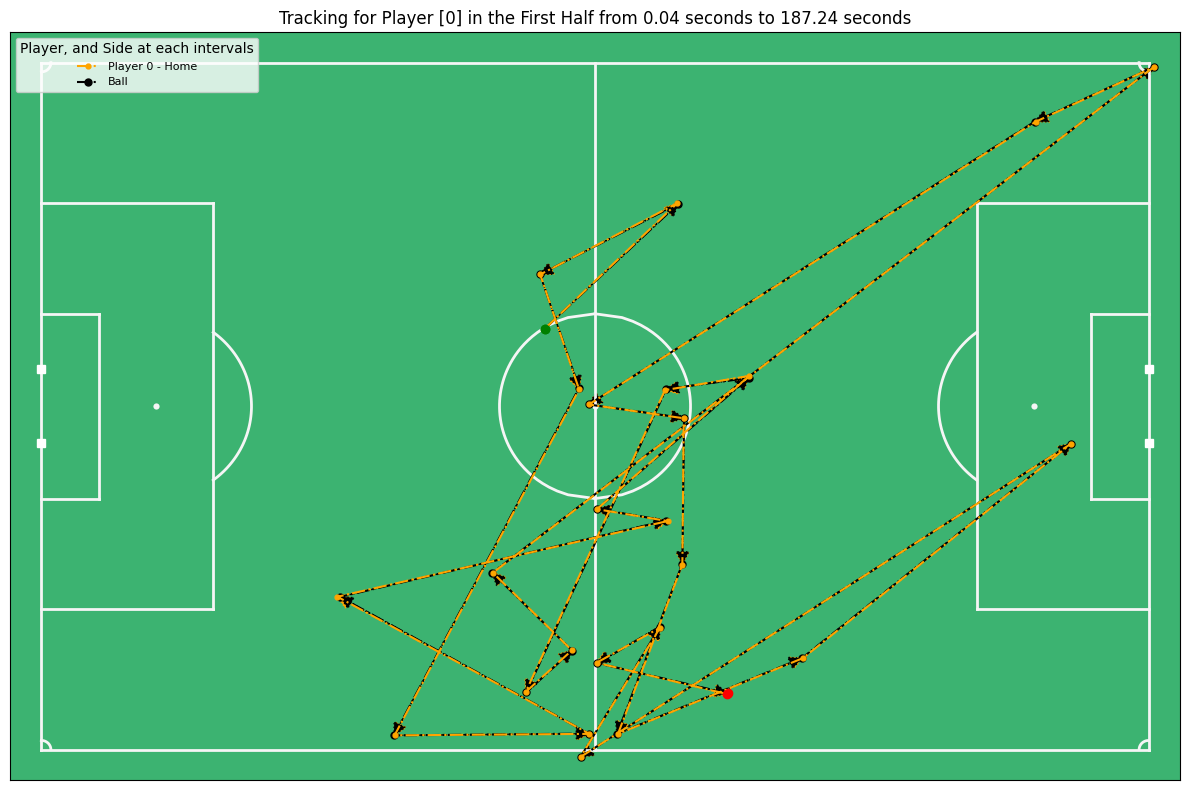

In [60]:
player_tracking(smallest_dataset, plot_ball=True, players=[0], use_annotation=None, sides=["Home"]) # Putting down [0] and ["Home"] because we don't want it to be different color and it's easier

# Classification

In [90]:
min_dist_to_ball

Time[s]  Home-P_0-x  Home-P_0-y  Away-P_19-x  Away-P_19-y  Home-P_10-x  \
1         0.04     0.45472     0.38709      0.45472      0.38709          NaN   
18        0.72     0.57428     0.20464          NaN          NaN          NaN   
19        0.76     0.57343     0.20364          NaN          NaN          NaN   
20        0.80     0.57249     0.20276          NaN          NaN          NaN   
21        0.84     0.57151     0.20183          NaN          NaN          NaN   
...        ...         ...         ...          ...          ...          ...   
67637  2705.48     0.96783     0.80203          NaN          NaN          NaN   
67638  2705.52     0.96890     0.80232          NaN          NaN          NaN   
67639  2705.56     0.97071     0.80246          NaN          NaN          NaN   
67640  2705.60     0.97339     0.80241          NaN          NaN          NaN   
67645  2705.80     0.98449     0.80214          NaN          NaN          NaN   

       Home-P_10-y  Home-P_11-x  Home-P_11-y  Away-P_15-x  ...  Home-P_8-x  \
1              NaN          NaN          NaN          NaN  ...         NaN   
18             NaN          NaN          NaN      0.57428  ...         NaN   
19             NaN          NaN          NaN      0.57343  ...         NaN   
20             NaN          NaN          NaN      0.57249  ...         NaN   
21             NaN          NaN          NaN      0.57151  ...         NaN   
...            ...          ...          ...          ...  ...         ...   
67637          NaN          NaN          NaN          NaN  ...     0.96783   
67638          NaN          NaN          NaN          NaN  ...     0.96890   
67639          NaN          NaN          NaN          NaN  ...     0.97071   
67640          NaN          NaN          NaN          NaN  ...     0.97339   
67645          NaN          NaN          NaN          NaN  ...     0.98449   

       Home-P_8-y  Away-P_23-x  Away-P_23-y  Home-P_5-x  Home-P_5-y  \
1             NaN          NaN          NaN         NaN         NaN   
18            NaN          NaN          NaN         NaN         NaN   
19            NaN          NaN          NaN         NaN         NaN   
20            NaN          NaN          NaN         NaN         NaN   
21            NaN          NaN          NaN         NaN         NaN   
...           ...          ...          ...         ...         ...   
67637     0.80203          NaN          NaN         NaN         NaN   
67638     0.80232          NaN          NaN         NaN         NaN   
67639     0.80246          NaN          NaN         NaN         NaN   
67640     0.80241          NaN          NaN         NaN         NaN   
67645     0.80214          NaN          NaN         NaN         NaN   

       Home-P_1-x  Home-P_1-y   ball-x   ball-y  
1             NaN         NaN  0.45472  0.38709  
18            NaN         NaN  0.57502  0.20554  
19            NaN         NaN  0.57426  0.20462  
20            NaN         NaN  0.57341  0.20362  
21            NaN         NaN  0.57247  0.20274  
...           ...         ...      ...      ...  
67637         NaN         NaN  0.96644  0.80210  
67638         NaN         NaN  0.96785  0.80203  
67639         NaN         NaN  0.96894  0.80232  
67640         NaN         NaN  0.97078  0.80245  
67645         NaN         NaN  0.98272  0.80215  

[15878 rows x 49 columns]

In [96]:
df_event = pd.read_csv("Sample_Game_2_RawEventsData.csv")
df_event_period_1 = df_event[df_event["Period"] == 1]
df_event_period_1

Team       Type          Subtype  Period  Start Frame  Start Time [s]  \
0     Away  SET PIECE         KICK OFF       1           51            2.04   
1     Away       PASS              NaN       1           51            2.04   
2     Away       PASS              NaN       1          146            5.84   
3     Away       PASS              NaN       1          248            9.92   
4     Away       PASS              NaN       1          316           12.64   
...    ...        ...              ...     ...          ...             ...   
1024  Home       PASS              NaN       1        66843         2673.72   
1025  Home       PASS              NaN       1        66929         2677.16   
1026  Home       SHOT   OFF TARGET-OUT       1        67067         2682.68   
1027  Away   RECOVERY              NaN       1        67118         2684.72   
1028  Away  BALL LOST  FORCED-END HALF       1        67852         2714.08   

      End Frame  End Time [s]      From        To  Start X  Start Y  End X  \
0            51          2.04  Player23       NaN      NaN      NaN    NaN   
1            87          3.48  Player23  Player20     0.50     0.50   0.40   
2           186          7.44  Player20  Player18     0.43     0.50   0.44   
3           283         11.32  Player18  Player17     0.47     0.19   0.31   
4           346         13.84  Player17  Player16     0.29     0.32   0.26   
...         ...           ...       ...       ...      ...      ...    ...   
1024      66878       2675.12   Player6   Player5     0.47     0.16   0.37   
1025      66961       2678.44   Player5   Player7     0.34     0.49   0.22   
1026      67107       2684.28   Player7       NaN     0.13     0.77  -0.02   
1027      67118       2684.72  Player25       NaN     0.04     0.50    NaN   
1028      67857       2714.28  Player25       NaN     0.00     0.51   0.01   

      End Y  
0       NaN  
1      0.51  
2      0.22  
3      0.28  
4      0.58  
...     ...  
1024   0.43  
1025   0.87  
1026   0.41  
1027    NaN  
1028   0.47  

[1029 rows x 14 columns]

In [97]:
df_event_period_1_y = df_event_period_1[["Type", "Start Frame", "End Frame"]]
df_event_period_1_y["Current Player"] = change_player_name(df_event_period_1["To"].combine_first(df_event_period_1["From"]))
df_event_period_1_y

C:\Users\noill\AppData\Local\Temp\ipykernel_41060\1484036386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_period_1_y["Current Player"] = change_player_name(df_event_period_1["To"].combine_first(df_event_period_1["From"]))


Type  Start Frame  End Frame Current Player
0     SET PIECE           51         51      Away-P_23
1          PASS           51         87      Away-P_20
2          PASS          146        186      Away-P_18
3          PASS          248        283      Away-P_17
4          PASS          316        346      Away-P_16
...         ...          ...        ...            ...
1024       PASS        66843      66878       Home-P_5
1025       PASS        66929      66961       Home-P_7
1026       SHOT        67067      67107       Home-P_7
1027   RECOVERY        67118      67118      Away-P_25
1028  BALL LOST        67852      67857      Away-P_25

[1029 rows x 4 columns]

In [98]:
start_frames = np.array(df_event_period_1_y["Start Frame"].iloc[1:]) + 2
end_frames = np.array(df_event_period_1_y["End Frame"].iloc[:-1]) - 2

In [99]:
assert start_frames.shape == end_frames.shape
frame_ranges = [np.sort(np.array([i, j])) for i, j in zip(end_frames, start_frames)]

In [100]:
X = [i[:-2] for i in dif_min_dist_to_ball.iloc[:, 3:-2].idxmax(axis=1)]
X_idxs = list(dif_min_dist_to_ball.index)
assert len(X_idxs) == len(X)

In [101]:
# def find_idxs_label(event_dataset, ranges, data, data_idxs):
#     assert len(data) == len(data_idxs)
    
#     i = 0
#     j = 0
#     result = []
#     while i < len(ranges) and j < len(data_idxs):
#         item = data_idxs[j]
#         if item > ranges[i][0] and item < ranges[i][1]:
#             if event_dataset.loc[i, "Current Player"] == data[j]:
#                 result.append(i)
#                 j += 1
#         i += 1

#     return result

In [102]:
def find_idxs_label(event_dataset, ranges, data, data_idxs):
    assert len(data) == len(data_idxs)
    
    i = 0  # range index
    j = 0  # data index
    result = []
    
    while i < len(ranges) and j < len(data_idxs):
        item = data_idxs[j]
        
        # Check if the item is within the current range
        if ranges[i][0] < item < ranges[i][1]:
            # Check if "Current Player" matches data[j] within the range
            if event_dataset.loc[i, "Current Player"] == data[j]:
                result.append(i)  # Record the index if there's a match
            
            # Move to the next data index to check for multiple events in the same range
            j += 1
        else:
            # Move to the next range when the current item is outside the current range
            if item >= ranges[i][1]:
                i += 1
            # If item is less than ranges[i][0], we only need to increment `j`
            elif item <= ranges[i][0]:
                j += 1

    return result

In [103]:
idxs_labels = find_idxs_label(df_event_period_1_y, frame_ranges, X, X_idxs) # TODO: need to fix this later because there can be many events in one interval
len(idxs_labels)

448

In [104]:
X = np.array(df_event_period_1_y.iloc[idxs_labels]["Type"])
y = np.array(df_event_period_1_y.iloc[idxs_labels]["Current Player"])
np.unique(X, return_counts=True)

(array(['BALL LOST', 'CHALLENGE', 'PASS', 'RECOVERY', 'SET PIECE'],
       dtype=object),
 array([  2,   7, 417,  14,   8], dtype=int64))

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Why random_state=42

In [106]:
X_test

array(['PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'RECOVERY', 'PASS',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'RECOVERY',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS',
       'RECOVERY', 'PASS', 'RECOVERY', 'SET PIECE', 'PASS', 'PASS',
       'PASS', 'PASS', 'RECOVERY', 'PASS', 'PASS', 'SET PIECE', 'PASS',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS',
       'SET PIECE', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS',
       'PASS', 'PASS', 'CHALLENGE', 'PASS', 'PASS', 'PASS', 'PASS',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS'],
      dtype=object)

In [107]:
# vectorizer = CountVectorizer()
# vectorizer.fit(X_train.ravel())
# X_train = vectorizer.transform(X_train.ravel())
# X_test = vectorizer.transform(X_test.ravel())
# X_train = X_train.toarray()
# X_test = X_test.toarray()

In [108]:
if len(X_train.shape) == 1:
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)

In [109]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), list(range(X_train.shape[1]))),
    ]
)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [110]:
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

In [111]:
lg = LogisticRegression(random_state=0)
lg.fit(X_train_resampled, y_train_resampled)
lg_y_pred = lg.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test, lg_y_pred)
print("Logistic regression accuracy:", accuracy)

Logistic regression accuracy: 0.08888888888888889


In [112]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train_resampled, y_train_resampled)
rfc_y_pred = rfc.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test, rfc_y_pred)
print("Random forest classifier accuracy:", accuracy)

Random forest classifier accuracy: 0.08888888888888889


In [113]:
adc = AdaBoostClassifier(random_state=0)
adc.fit(X_train_resampled, y_train_resampled)
adc_y_pred = adc.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test, adc_y_pred)
print("AdaBoost classifier accuracy:", accuracy)

AdaBoost classifier accuracy: 0.05555555555555555
